#**DATA WRAGLING - DATOS DE CALIDAD DEL AIRE**

## **CONTEXTO DEL DATASET**


El dataset abarca datos recopilados durante un año (del 1 de mayo de 2014 al 30 de abril de 2015) en 4 ciudades principales de China (Beijing, Tianjin, Guangzhou y Shenzhen) y 39 ciudades cercanas dentro de un radio de 300 km, divididas en dos clústeres:
- **Clúster A**: 19 ciudades cerca de Beijing.
- **Clúster B**: 24 ciudades cerca de Guangzhou.

Consta de seis partes principales:
1. **City Data** (`city.csv`): Información de 43 ciudades, incluyendo ID, nombre (chino e inglés), coordenadas (latitud, longitud) y clúster (A o B).
2. **District Data** (`district.csv`): Detalles de 380 distritos en las 43 ciudades, con ID, nombre y City ID asociado.
3. **Air Quality Monitoring Station Data** (`station.csv`): Información de 437 estaciones de monitoreo de calidad del aire, con ID, nombre, coordenadas y District ID.
4. **Air Quality Data** (`airquality.csv`): 2,891,393 registros horarios de calidad del aire en las 437 estaciones, con concentraciones de seis contaminantes (PM2.5, PM10, NO2, CO, O3, SO2). Incluye valores faltantes, especialmente en PM10 (45.1% en Beijing).
5. **Meteorological Data** (`meteorology.csv`): 1,898,453 registros horarios de meteorología a nivel de distrito/ciudad, con variables como clima, temperatura, presión, humedad, velocidad y dirección del viento. También presenta valores faltantes (e.g., 24.2% en clima para Beijing).
6. **Weather Forecast Data** (`weatherforecast.csv`): 910,576 registros de pronósticos meteorológicos para los próximos dos días, con granularidad temporal de 3, 6 o 12 horas, incluyendo clima, temperatura, nivel de viento y dirección.

### **Características Clave**
- **Escala**: Gran volumen de datos (millones de registros) que cubren aspectos geográficos, temporales y ambientales.
- **Granularidad**: Datos a nivel de ciudad, distrito y estación, con registros horarios (calidad del aire y meteorología) y pronósticos con diferentes granularidades temporales.
- **Aplicaciones**: Utilizado para inferir calidad del aire a nivel fino (actual y futuro) y en tareas de aprendizaje automático como aprendizaje multi-vista, multi-tarea y transferencia.
- **Desafíos de Datos**:
  - Valores faltantes significativos (e.g., 45.1% en PM10 para Beijing).
  - Datos sucios como valores atípicos o duplicados debido a errores en la recolección o publicación.
- **Distribución de Calidad del Aire**: Beijing y Tianjin tienen peor calidad del aire que Guangzhou y Shenzhen, con mayores concentraciones de PM2.5 en meses fríos.
- **Meteorología**: Alta presencia de días soleados (47.67% en Beijing) y condiciones como niebla/polvo (~10%).


In [ ]:
# EDA_and_Preprocessing_AirQuality_Forecasting.ipynb

# 📌 Paso 0: Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import drive

# Activar Google Drive
drive.mount('/content/drive')

# 📁 Ruta base donde están los CSVs (modifica según tu carpeta en Drive)
base_path = '/content/drive/MyDrive/5to/CIENCIA DE DATOS/IDEA PROYECTO/bd/'

# 📌 Paso 1: Carga de datos
airquality = pd.read_csv(base_path + 'airquality.csv')
city = pd.read_csv(base_path + 'city.csv')
district = pd.read_csv(base_path + 'district.csv')
meteorology = pd.read_csv(base_path + 'meteorology.csv')
station = pd.read_csv(base_path + 'station.csv')
weatherforecast = pd.read_csv(base_path + 'weatherforecast.csv')

Mounted at /content/drive


In [ ]:
import chardet

# Función para detectar el encoding de un archivo
def detectar_encoding(ruta_archivo):
    with open(ruta_archivo, 'rb') as f:
        result = chardet.detect(f.read(10000))  # Leer primeros 10,000 bytes
    return result

# Verificar encoding de cada archivo
archivos = ['airquality.csv', 'city.csv', 'district.csv', 'meteorology.csv', 'station.csv', 'weatherforecast.csv']

for archivo in archivos:
    ruta = base_path + archivo
    encoding_detectado = detectar_encoding(ruta)
    print(f"{archivo}: {encoding_detectado['encoding']} (confianza: {encoding_detectado['confidence']:.2f})")


airquality.csv: UTF-8-SIG (confianza: 1.00)
city.csv: UTF-8-SIG (confianza: 1.00)
district.csv: UTF-8-SIG (confianza: 1.00)
meteorology.csv: UTF-8-SIG (confianza: 1.00)
station.csv: UTF-8-SIG (confianza: 1.00)
weatherforecast.csv: UTF-8-SIG (confianza: 1.00)


In [ ]:
# 📌 Paso 2: Mostrar las primeras 5 filas de cada tabla
print("1. Air Quality Data (airquality.csv):")
print(airquality.head())
print("\n2. City Data (city.csv):")
print(city.head())
print("\n3. District Data (district.csv):")
print(district.head())
print("\n4. Meteorology Data (meteorology.csv):")
print(meteorology.head())
print("\n5. Station Data (station.csv):")
print(station.head())
print("\n6. Weather Forecast Data (weatherforecast.csv):")
print(weatherforecast.head())

1. Air Quality Data (airquality.csv):
   station_id                 time  PM25_Concentration  PM10_Concentration  \
0        1001  2014-05-01 00:00:00               138.0               159.4   
1        1001  2014-05-01 01:00:00               124.0               163.9   
2        1001  2014-05-01 02:00:00               127.0               148.4   
3        1001  2014-05-01 03:00:00               129.0               145.6   
4        1001  2014-05-01 04:00:00               119.0               119.3   

   NO2_Concentration  CO_Concentration  O3_Concentration  SO2_Concentration  
0               56.3               0.9              50.8               17.2  
1               38.7               0.9              51.1               17.9  
2               55.6               1.0              27.2               16.6  
3               65.7               1.0               9.7               16.7  
4               66.9               1.0               2.0               16.5  

2. City Data (city.csv):

# **P1. Analiza el comportamiento de tus datos.**


### **1.1. ¿Qué representa un registro?**
Un **registro** es una fila en cada archivo CSV, y su significado depende de la tabla:


- **`airquality.csv`**: Un registro representa la medición de calidad del aire en una estación de monitoreo específica en un momento dado (hora). Incluye concentraciones de seis contaminantes (PM2.5, PM10, NO2, CO, O3, SO2).
- **`city.csv`**: Un registro representa una ciudad, con información como su ID, nombre (chino e inglés), coordenadas geográficas y clúster (A o B).
- **`district.csv`**: Un registro representa un distrito dentro de una ciudad, con su ID, nombre y el ID de la ciudad a la que pertenece.
- **`meteorology.csv`**: Un registro representa las condiciones meteorológicas en un distrito o ciudad en un momento específico (hora), incluyendo clima, temperatura, presión, humedad, velocidad y dirección del viento.
- **`station.csv`**: Un registro representa una estación de monitoreo de calidad del aire, con su ID, nombre, coordenadas y el ID del distrito al que pertenece.
- **`weatherforecast.csv`**: Un registro representa un pronóstico meteorológico para un distrito o ciudad en un momento futuro, con granularidad temporal de 3, 6 o 12 horas, incluyendo clima, dirección del viento, temperaturas y nivel de viento.


### **1.2. ¿Cuántos registros hay?**
Según la descripción del dataset:
- **`airquality.csv`**: 2,891,393 registros.
- **`city.csv`**: 43 registros (uno por ciudad).
- **`district.csv`**: 380 registros (uno por distrito).
- **`meteorology.csv`**: 1,898,453 registros.
- **`station.csv`**: 437 registros (uno por estación de monitoreo).
- **`weatherforecast.csv`**: 910,576 registros.


In [ ]:
print("Número de registros por tabla:")
print(f"Air Quality: {len(airquality)}")
print(f"City: {len(city)}")
print(f"District: {len(district)}")
print(f"Meteorology: {len(meteorology)}")
print(f"Station: {len(station)}")
print(f"Weather Forecast: {len(weatherforecast)}")

Número de registros por tabla:
Air Quality: 2891393
City: 43
District: 380
Meteorology: 1898453
Station: 437
Weather Forecast: 910576


**1.2.1. ¿Son demasiado pocos?**:
  - `city.csv` (43 registros) y `station.csv` (437 registros) tienen pocos registros, lo que los hace fáciles de procesar y no representa un problema.
  - `district.csv` (380 registros) también es manejable.
  - `airquality.csv` (2.89M registros), `meteorology.csv` (1.89M registros) y `weatherforecast.csv` (910K registros) tienen un volumen significativo, adecuado para análisis de series temporales y modelado predictivo, por lo que no son "demasiado pocos" para tareas como pronósticos de calidad del aire.


**1.2.2. ¿Son muchos y no tenemos capacidad (CPU+RAM) suficiente para procesarlo?**:
  - Los tamaños de los datasets más grandes (`airquality` y `meteorology`) son considerables pero manejables en entornos modernos como Google Colab, que ofrece ~12 GB de RAM (en la versión gratuita) y hasta ~25 GB en Colab Pro. Suponiendo un tamaño aproximado:
    - `airquality.csv`: ~2.89M filas × 8 columnas (Station ID, Time, 6 contaminantes) × ~8 bytes por valor (float64) ≈ 185 MB.
    - `meteorology.csv`: ~1.89M filas × 8 columnas × ~8 bytes ≈ 121 MB.
    - `weatherforecast.csv`: ~910K filas × 9 columnas × ~8 bytes ≈ 65 MB.
  - Estos tamaños son manejables en la mayoría de los entornos con 8-16 GB de RAM. Sin embargo, operaciones intensivas (e.g., uniones de tablas grandes o modelos de machine learning complejos) podrían requerir optimizaciones, como:
    - Usar `chunks` en pandas para leer datos en partes.
    - Usar tipos de datos más eficientes (e.g., `float32` en lugar de `float64`, `category` para variables categóricas).
    - Filtrar datos por ciudad o período para reducir el volumen.

**1.2.3. ¿Hay datos duplicados?**

Para verificar duplicados, podemos usar el método `.duplicated()` de pandas. Los duplicados pueden surgir por errores en la recolección de datos (como se mencionó en el contexto, debido a fallos en los crawlers o datos oficiales incorrectos).


In [ ]:
print("Datos duplicados por tabla:")
print(f"Air Quality: {airquality.duplicated().sum()} duplicados")
print(f"City: {city.duplicated().sum()} duplicados")
print(f"District: {district.duplicated().sum()} duplicados")
print(f"Meteorology: {meteorology.duplicated().sum()} duplicados")
print(f"Station: {station.duplicated().sum()} duplicados")
print(f"Weather Forecast: {weatherforecast.duplicated().sum()} duplicados")

Datos duplicados por tabla:
Air Quality: 0 duplicados
City: 0 duplicados
District: 0 duplicados
Meteorology: 0 duplicados
Station: 0 duplicados
Weather Forecast: 0 duplicados


### **1.3. ¿Qué datos son discretos y cuáles continuos?**
- **Discretos**: Valores que toman un conjunto finito o numerable de valores (e.g., categorías, enteros).
- **Continuos**: Valores que pueden tomar cualquier valor dentro de un rango (e.g., números reales).


**1.3.1. Análisis por tabla**:
- **`airquality.csv`**:
  - **Discretos**: `Station ID` (categórico, identificador), `Time` (aunque es una marca temporal, se trata como discreta en análisis categórico).
  - **Continuos**: `PM25`, `PM10`, `NO2`, `CO`, `O3`, `SO2` (concentraciones de contaminantes, valores reales).
- **`city.csv`**:
  - **Discretos**: `City ID` (identificador), `Chinese Name`, `English Name`, `Cluster ID` (1 o 2, categórico).
  - **Continuos**: `Latitude`, `Longitude`.
- **`district.csv`**:
  - **Discretos**: `District ID`, `Chinese Name`, `English Name`, `City ID` (todos categóricos o identificadores).
  - **Continuos**: Ninguno.
- **`meteorology.csv`**:
  - **Discretos**: `ID` (District/City ID), `Time`, `Weather` (0-16, categórico), `Wind Direction` (0-9, 13-24, categórico).
  - **Continuos**: `Temperature` (°C), `Pressure` (hPa), `Humidity` (%), `Wind Speed` (m/s).
- **`station.csv`**:
  - **Discretos**: `Station ID`, `Chinese Name`, `English Name`, `District ID` (todos categóricos o identificadores).
  - **Continuos**: `Latitude`, `Longitude`.
- **`weatherforecast.csv`**:
  - **Discretos**: `ID`, `Forecast Time`, `Future Time`, `Temporal Granularity` (3, 6, 12), `Weather` (0-16), `Wind Direction` (0-9, 13-24).
  - **Continuos**: `Up Temperature`, `Bottom Temperature`, `Wind Level` (e.g., 3.5, 4.5).

 **1.3.2. ¿Cuáles son los tipos de datos de cada columna?**

Para obtener los tipos de datos, usamos `df.dtypes`. A continuación, detallo los tipos esperados basados en la descripción y cómo verificarlos.

*1.3.2.1.Tipos esperados*:
- **`airquality.csv`**:
  - `Station ID`: object (string, e.g., "001001").
  - `Time`: object (string, formato "YYYY-MM-DD HH:MM:SS"; debe convertirse a `datetime64`).
  - `PM25`, `PM10`, `NO2`, `CO`, `O3`, `SO2`: float64 (concentraciones, pueden incluir NaN).
- **`city.csv`**:
  - `City ID`: object (string, e.g., "001").
  - `Chinese Name`, `English Name`: object (string).
  - `Latitude`, `Longitude`: float64.
  - `Cluster ID`: int64 (1 o 2).
- **`district.csv`**:
  - `District ID`, `City ID`: object (string, e.g., "00101", "001").
  - `Chinese Name`, `English Name`: object (string).
- **`meteorology.csv`**:
  - `ID`: object (string, District/City ID).
  - `Time`: object (string, formato "YYYY-MM-DD HH:MM:SS"; debe convertirse a `datetime64`).
  - `Weather`, `Wind Direction`: int64 (categóricos codificados).
  - `Temperature`, `Pressure`, `Humidity`, `Wind Speed`: float64.
- **`station.csv`**:
  - `Station ID`, `District ID`: object (string, e.g., "001001", "00101").
  - `Chinese Name`, `English Name`: object (string).
  - `Latitude`, `Longitude`: float64.
- **`weatherforecast.csv`**:
  - `ID`: object (string, District/City ID).
  - `Forecast Time`, `Future Time`: object (string, formato "YYYY-MM-DD HH:MM:SS"; debe convertirse a `datetime64`).
  - `Temporal Granularity`, `Weather`, `Wind Direction`: int64 (categóricos).
  - `Up Temperature`, `Bottom Temperature`, `Wind Level`: float64.




In [ ]:
print("Tipos de datos por tabla:")
print("\nAir Quality:")
print(airquality.dtypes)
print("\nCity:")
print(city.dtypes)
print("\nDistrict:")
print(district.dtypes)
print("\nMeteorology:")
print(meteorology.dtypes)
print("\nStation:")
print(station.dtypes)
print("\nWeather Forecast:")
print(weatherforecast.dtypes)

Tipos de datos por tabla:

Air Quality:
station_id              int64
time                   object
PM25_Concentration    float64
PM10_Concentration    float64
NO2_Concentration     float64
CO_Concentration      float64
O3_Concentration      float64
SO2_Concentration     float64
dtype: object

City:
city_id           int64
name_chinese     object
name_english     object
latitude        float64
longitude       float64
cluster_id        int64
dtype: object

District:
district_id      int64
name_chinese    object
name_english    object
city_id          int64
dtype: object

Meteorology:
id                  int64
time               object
weather           float64
temperature       float64
pressure          float64
humidity          float64
wind_speed        float64
wind_direction    float64
dtype: object

Station:
station_id        int64
name_chinese     object
name_english     object
latitude        float64
longitude       float64
district_id       int64
dtype: object

Weather Forecast:
i

**1.3.3. ¿Entre qué rangos están los datos de cada columna? Valores únicos, min, max**

Para obtener rangos, valores únicos, mínimos y máximos, usamos métodos como `describe()`, `nunique()`, `min()`, y `max()`.

In [ ]:
def analyze_ranges(df, name):
    print(f"\nAnálisis de {name}:")
    print("Valores únicos por columna:")
    print(df.nunique())
    print("\nEstadísticas descriptivas (numéricas):")
    print(df.describe())
    print("\nValores mínimos y máximos (incluyendo categóricos):")
    for col in df.columns:
        print(f"{col}: Min = {df[col].min()}, Max = {df[col].max()}")

# Ejecutar para cada tabla
analyze_ranges(airquality, "Air Quality")
analyze_ranges(city, "City")
analyze_ranges(district, "District")
analyze_ranges(meteorology, "Meteorology")
analyze_ranges(station, "Station")
analyze_ranges(weatherforecast, "Weather Forecast")


Análisis de Air Quality:
Valores únicos por columna:
station_id              437
time                   8689
PM25_Concentration      956
PM10_Concentration     6313
NO2_Concentration      2928
CO_Concentration      23802
O3_Concentration       3342
SO2_Concentration      2416
dtype: int64

Estadísticas descriptivas (numéricas):
         station_id  PM25_Concentration  PM10_Concentration  \
count  2.891393e+06        2.845508e+06        2.655505e+06   
mean   3.334194e+04        6.906838e+01        1.155133e+02   
std    5.183133e+04        6.910366e+01        1.033460e+02   
min    1.001000e+03        1.000000e+00        1.000000e-01   
25%    9.037000e+03        2.500000e+01        4.600000e+01   
50%    1.701800e+04        4.700000e+01        8.400000e+01   
75%    2.900400e+04        8.900000e+01        1.520000e+02   
max    3.720020e+05        1.463000e+03        1.498000e+03   

       NO2_Concentration  CO_Concentration  O3_Concentration  \
count       2.832229e+06      2.79761

| **Tabla**            | **Columna**               | **Mínimo**            | **Máximo**            | **Rango Normal Esperado (China, 2014-2015)** | **Análisis de Anomalías** |
|-----------------------|---------------------------|-----------------------|-----------------------|---------------------------------------------|---------------------------|
| **Air Quality**       | station_id                | 1001                  | 372002                | 1 a ~1000000 (identificadores únicos)       | No anomalías; rango amplio pero válido para identificadores. |
|                       | time                      | 1970-01-01 08:00:00  | 2015-04-30 23:00:00  | 2014-05-01 a 2015-04-30                   | Mínimo (1970-01-01) es anómalo; fuera del período esperado. Probable error de registro. |
|                       | PM25_Concentration        | 1.0                   | 1463.0                | 0 a 500 µg/m³ (picos >500 posibles en smog) | Máximo (1463.0) es extremo pero plausible en episodios de smog. Mínimo (1.0) válido. |
|                       | PM10_Concentration        | 0.1                   | 1498.0                | 0 a 1000 µg/m³ (picos >1000 posibles)      | Máximo (1498.0) es extremo pero plausible. Mínimo (0.1) podría ser error de sensor. |
|                       | NO2_Concentration         | 0.0                   | 499.7                 | 0 a 200 µg/m³ (picos >200 raros)           | Mínimo (0.0) podría ser datos faltantes o error. Máximo (499.7) es anómalo; validar. |
|                       | CO_Concentration          | 0.0                   | 46.466                | 0 a 10 mg/m³ (picos >10 posibles)          | Mínimo (0.0) podría ser error. Máximo (46.466) es extremo pero plausible en áreas industriales. |
|                       | O3_Concentration          | 0.0                   | 500.0                 | 0 a 300 µg/m³ (picos >300 raros)           | Mínimo (0.0) podría ser error. Máximo (500.0) es anómalo; probable error de sensor. |
|                       | SO2_Concentration         | 0.0                   | 999.0                 | 0 a 500 µg/m³ (picos >500 raros)           | Mínimo (0.0) podría ser error. Máximo (999.0) es anómalo; probable error o evento extremo. |
| **City**              | city_id                   | 1                     | 372                   | 1 a ~500 (identificadores únicos)           | No anomalías; rango amplio pero válido para identificadores. |
|                       | latitude                  | 21.662998             | 40.952942             | 18 a 53 (latitudes de China continental)    | Válido; cubre regiones desde Hainan hasta Heilongjiang. |
|                       | longitude                 | 110.925456            | 119.600493            | 73 a 135 (longitudes de China continental)  | Válido; cubre regiones orientales (e.g., Guangdong a Shandong). |
|                       | cluster_id                | 1                     | 2                     | 1 a n (categórica, número de clústeres)     | Solo 2 valores; no anomalías, pero baja variabilidad. |
| **District**          | district_id               | 101                   | 37204                 | 1 a ~100000 (identificadores únicos)        | No anomalías; rango amplio pero válido para identificadores. |
|                       | city_id                   | 1                     | 372                   | 1 a ~500 (debe coincidir con City)          | Válido; coincide con city_id en City. |
| **Meteorology**       | id                        | 1                     | 37203                 | 1 a ~100000 (identificadores únicos)        | No anomalías; rango amplio pero válido. |
|                       | weather                   | 0.0                   | 16.0                  | 0 a ~20 (códigos categóricos de clima)      | 0.0 podría ser datos faltantes o categoría válida (e.g., despejado). |
|                       | temperature               | -27.0                 | 41.0                  | -30 a 45°C (típico en China)               | Válido; -27°C plausible en invierno, 41°C en verano. |
|                       | pressure                  | 745.7                 | 1050.0                | 950 a 1050 hPa (típico en China)           | Mínimo (745.7) es anómalo; muy bajo para condiciones normales. |
|                       | humidity                  | 0.0                   | 100.0                 | 5 a 100% (típico en China)                 | Mínimo (0.0) es anómalo; humedad 0% es rara. |
|                       | wind_speed                | 0.0                   | 95.5                  | 0 a 50 m/s (típico; >50 en tormentas)      | Máximo (95.5) es extremo; podría ser válido en tormentas. |
|                       | wind_direction            | 0.0                   | 24.0                  | 0 a 360° o categórica (e.g., 0-16)         | 0.0 podría ser datos faltantes o categoría válida. |
| **Station**           | station_id                | 1001                  | 372002                | 1 a ~1000000 (identificadores únicos)       | No anomalías; rango amplio pero válido. |
|                       | latitude                  | 21.4689               | 41.956                | 18 a 53 (latitudes de China continental)    | Válido; similar a City. |
|                       | longitude                 | 110.866667            | 119.762               | 73 a 135 (longitudes de China continental)  | Válido; similar a City. |
|                       | district_id               | 101                   | 37204                 | 1 a ~100000 (debe coincidir con District)   | Válido; coincide con District. |
| **Weather Forecast**   | id                        | 1                     | 911                   | 1 a ~1000 (identificadores únicos)          | No anomalías; rango pequeño pero válido. |
|                       | frequent                  | 3                     | 12                    | 3 a 24 (horas de pronóstico)               | Válido; representa intervalos de pronóstico. |
|                       | weather                   | 0.0                   | 16.0                  | 0 a ~20 (códigos categóricos de clima)      | 0.0 podría ser datos faltantes o categoría válida. |
|                       | up_temperature            | -14.0                 | 39.0                  | -20 a 45°C (típico en China)               | Válido; rangos plausibles para pronósticos. |
|                       | bottom_temperature        | -20.0                 | 39.0                  | -25 a 45°C (típico en China)               | Válido; rangos plausibles. |
|                       | wind_level                | 0.0                   | 6.5                   | 0 a 12 (escala Beaufort o similar)          | Máximo (6.5) es válido; 0.0 podría ser datos faltantes. |
|                       | wind_direction            | 0.0                   | 24.0                  | 0 a 360° o categórica (e.g., 0-16)         | 0.0 podría ser datos faltantes o categoría válida. |

Extraemos de esta tabla los casos raros en cada tabla, obteniendo:

| **Tabla**            | **Columna**               | **Valor Anómalo** | **Tipo de Anomalía** | **Análisis de Anomalía** |
|-----------------------|---------------------------|-------------------|----------------------|--------------------------|
| **Air Quality**       | time                      | 1970-01-01 08:00:00 | Mínimo               | Fuera del período esperado (2014-05-01 a 2015-04-30). Probable error de registro o datos históricos irrelevantes. |
|                       | PM25_Concentration        | 1463.0            | Máximo               | Extremo (1463.0 µg/m³), pero plausible en episodios de smog severo en China (2014-2015). Requiere validación con datos históricos. |
|                       | PM10_Concentration        | 1498.0            | Máximo               | Extremo (1498.0 µg/m³), pero posible en eventos de contaminación. |
|                       | PM10_Concentration        | 0.1               | Mínimo               | Muy bajo; podría ser error de sensor o medición no detectada. |
|                       | NO2_Concentration         | 0.0               | Mínimo               | Improbable; concentraciones de NO2 rara vez son 0.0. Posible datos faltantes o error. |
|                       | NO2_Concentration         | 499.7             | Máximo               | Muy alto (>200 µg/m³ es raro); probable error o evento extremo. Requiere validación. |
|                       | CO_Concentration          | 0.0               | Mínimo               | Improbable; concentraciones de CO rara vez son 0.0. Posible error o datos no detectados. |
|                       | CO_Concentration          | 46.466            | Máximo               | Extremo, pero plausible en áreas industriales. Validar con contexto. |
|                       | O3_Concentration          | 0.0               | Mínimo               | Improbable; niveles de O3 rara vez son 0.0. Posible error o datos faltantes. |
|                       | O3_Concentration          | 500.0             | Máximo               | Muy alto (>300 µg/m³ es raro); probable error de sensor. Requiere validación. |
|                       | SO2_Concentration         | 0.0               | Mínimo               | Improbable; concentraciones de SO2 rara vez son 0.0. Posible error o datos no detectados. |
|                       | SO2_Concentration         | 999.0             | Máximo               | Muy alto (>500 µg/m³ es raro); probable error o evento extremo (e.g., emisión industrial). |
| **Meteorology**       | pressure                  | 745.7             | Mínimo               | Muy bajo (<950 hPa raro en China); probable error de medición. |
|                       | humidity                  | 0.0               | Mínimo               | Improbable; humedad relativa de 0% es rara en condiciones naturales. Posible error. |
|                       | wind_speed                | 95.5              | Máximo               | Extremo (~343 km/h); posible en tormentas severas, pero requiere validación. |
| **Weather Forecast**   | weather                   | 0.0               | Mínimo               | Podría ser datos faltantes o categoría válida (e.g., despejado). Requiere mapeo a categorías descriptivas. |
|                       | wind_level                | 0.0               | Mínimo               | Podría ser calma (válido) o datos faltantes. Requiere validación con contexto meteorológico. |
|                       | wind_direction            | 0.0               | Mínimo               | Podría ser datos faltantes o categoría válida (e.g., sin dirección). Requiere mapeo a categorías descriptivas. |

In [ ]:
airquality['time'] = pd.to_datetime(airquality['time'], errors='coerce')
meteorology['time'] = pd.to_datetime(meteorology['time'], errors='coerce')
weatherforecast['time_forecast'] = pd.to_datetime(weatherforecast['time_forecast'], errors='coerce')
weatherforecast['time_future'] = pd.to_datetime(weatherforecast['time_future'], errors='coerce')

# 📌 Función para mostrar la fila con el valor mínimo en la columna de tiempo
def show_min_time_row(df, time_column, table_name):
    print(f"\nTabla: {table_name}")
    if df[time_column].isna().all():
        print(f"  - No hay valores válidos en la columna '{time_column}'.")
        return

    # Encontrar el valor mínimo en la columna de tiempo
    min_time = df[time_column].min()
    # Seleccionar la fila (o filas) con el valor mínimo
    min_time_rows = df[df[time_column] == min_time]

    print(f"  - Valor mínimo en '{time_column}': {min_time}")
    print(f"  - Número de filas con este valor: {len(min_time_rows)}")
    print("  - Fila(s) con el valor mínimo:")
    print(min_time_rows)

    # Verificar si la fecha mínima está fuera del rango esperado (2014-05-01 a 2015-04-30)
    if min_time < pd.Timestamp('2014-05-01'):
        print(f"  - ¡Anomalía! Fecha mínima ({min_time}) anterior al rango esperado (2014-05-01).")

# 📌 Ejecutar para cada columna de tiempo en las tablas relevantes
show_min_time_row(airquality, 'time', 'Air Quality')
show_min_time_row(meteorology, 'time', 'Meteorology')
show_min_time_row(weatherforecast, 'time_forecast', 'Weather Forecast (Forecast Time)')
show_min_time_row(weatherforecast, 'time_future', 'Weather Forecast (Future Time)')

# 📌 Opcional: Filtrar filas con fechas anómalas en airquality
print("\nFiltrando fechas anómalas en Air Quality (anteriores a 2014-05-01):")
invalid_dates = airquality[airquality['time'].dt.year < 2014]
if not invalid_dates.empty:
    print(f"  - {len(invalid_dates)} registros con fechas anómalas:")
    print(invalid_dates)
else:
    print("  - No se encontraron fechas anómalas.")


Tabla: Air Quality
  - Valor mínimo en 'time': 1970-01-01 08:00:00
  - Número de filas con este valor: 6
  - Fila(s) con el valor mínimo:
         station_id                time  PM25_Concentration  \
2875173      371001 1970-01-01 08:00:00                55.0   
2877866      371002 1970-01-01 08:00:00                61.0   
2880629      371003 1970-01-01 08:00:00                72.0   
2883399      371004 1970-01-01 08:00:00                64.0   
2886238      372001 1970-01-01 08:00:00                61.0   
2888872      372002 1970-01-01 08:00:00                48.0   

         PM10_Concentration  NO2_Concentration  CO_Concentration  \
2875173                73.0                6.0             0.577   
2877866                78.0               19.0             2.484   
2880629                56.0               12.0             0.988   
2883399                74.0               13.0             0.623   
2886238                80.0               20.0             1.266   
2888872    

**1.3.4. ¿Todos los datos están en su formato adecuado?**

In [ ]:
def check_dtypes(df, name):
    print(f"\nTipos de datos en {name}:")
    print(df.dtypes)
    print("\nValores de ejemplo (primeras 2 filas):")
    print(df.head(2))

# Ejecutar para cada tabla
check_dtypes(airquality, "Air Quality")
check_dtypes(city, "City")
check_dtypes(district, "District")
check_dtypes(meteorology, "Meteorology")
check_dtypes(station, "Station")
check_dtypes(weatherforecast, "Weather Forecast")


Tipos de datos en Air Quality:
station_id              int64
time                   object
PM25_Concentration    float64
PM10_Concentration    float64
NO2_Concentration     float64
CO_Concentration      float64
O3_Concentration      float64
SO2_Concentration     float64
dtype: object

Valores de ejemplo (primeras 2 filas):
   station_id                 time  PM25_Concentration  PM10_Concentration  \
0        1001  2014-05-01 00:00:00               138.0               159.4   
1        1001  2014-05-01 01:00:00               124.0               163.9   

   NO2_Concentration  CO_Concentration  O3_Concentration  SO2_Concentration  
0               56.3               0.9              50.8               17.2  
1               38.7               0.9              51.1               17.9  

Tipos de datos en City:
city_id           int64
name_chinese     object
name_english     object
latitude        float64
longitude       float64
cluster_id        int64
dtype: object

Valores de ejemplo (p

*1.3.4.1. Tabla de Tipos de Datos*


| **Tabla**                | **Columna**                  | **Tipo Actual** | **Tipo Esperado** | **Contexto y Razón para el Cambio**                                                                 |
|--------------------------|------------------------------|-----------------|-------------------|---------------------------------------------------------------------------------------------|
| **Air Quality**          | `station_id`                | `int64`         | `category`        | **Contexto**: Identificador único de estaciones de monitoreo (437 valores únicos). Se usa para unir con `station.csv` o filtrar datos por estación. **Razón**: Como identificador categórico, no se realizan operaciones matemáticas. `category` reduce el uso de memoria (crucial para 2.89M registros) y refleja su naturaleza no numérica. |
|                          | `time`                      | `object`        | `datetime64`      | **Contexto**: Marca temporal de la medición de calidad del aire (horaria). Esencial para análisis de series temporales y predicción. **Razón**: `object` (string) no permite operaciones temporales (e.g., extraer año, mes). `datetime64` facilita agrupaciones, filtrado por fechas y cálculos de diferencias temporales. Anomalía ("1970-01-01") indica necesidad de conversión y limpieza. |
|                          | `PM25_Concentration`, `PM10_Concentration`, `NO2_Concentration`, `CO_Concentration`, `O3_Concentration`, `SO2_Concentration` | `float64` | `float64`         | **Contexto**: Concentraciones de contaminantes (µg/m³, excepto CO en mg/m³). Variables objetivo para predicción de calidad del aire. **Razón**: `float64` es adecuado para valores continuos con posibles NaN (e.g., 8.2% faltantes en PM10). No requiere cambio. Opcionalmente, `float32` podría usarse para ahorrar memoria si la precisión no es crítica. |
| **City**                | `city_id`                   | `int64`         | `category`        | **Contexto**: Identificador único de ciudades (43 valores). Usado para unir con `district.csv` o filtrar datos. **Razón**: No se realizan operaciones matemáticas. `category` ahorra memoria y refleja su naturaleza categórica. |
|                          | `name_chinese`, `name_english` | `object`     | `object`          | **Contexto**: Nombres de ciudades en chino e inglés. Usados para etiquetas en visualizaciones o reportes. **Razón**: `object` es correcto para strings. No requiere cambio. |
|                          | `latitude`, `longitude`     | `float64`       | `float64`         | **Contexto**: Coordenadas geográficas de la ciudad. Usadas para análisis espacial (e.g., mapas). **Razón**: `float64` es adecuado para valores continuos de alta precisión. No requiere cambio. |
|                          | `cluster_id`                | `int64`         | `category`        | **Contexto**: Identifica el clúster (1=Cluster A, 2=Cluster B). Usado para agrupar ciudades (solo 2 valores). **Razón**: `category` es más eficiente y refleja su naturaleza categórica no ordinal. |
| **District**            | `district_id`, `city_id`    | `int64`         | `category`        | **Contexto**: Identificadores de distritos (380 valores) y ciudades (43 valores). Usados para unir con `station.csv` o `meteorology.csv`. **Razón**: No se realizan operaciones matemáticas. `category` reduce memoria y es más apropiado. |
|                          | `name_chinese`, `name_english` | `object`     | `object`          | **Contexto**: Nombres de distritos. Usados para etiquetas o reportes. **Razón**: `object` es correcto para strings. No requiere cambio. |
| **Meteorology**         | `id`                        | `int64`         | `category`        | **Contexto**: Identificador de distrito/ciudad (345 valores). Usado para unir con `weatherforecast.csv` o `district.csv`. **Razón**: `category` es más eficiente para identificadores categóricos y reduce memoria en 1.89M registros. |
|                          | `time`                      | `object`        | `datetime64`      | **Contexto**: Marca temporal de la medición meteorológica (horaria). Clave para correlacionar con `airquality.csv`. **Razón**: `object` no permite operaciones temporales. `datetime64` facilita análisis de series temporales y uniones temporales. |
|                          | `weather`, `wind_direction` | `float64`       | `category`        | **Contexto**: Códigos categóricos (17 y 10 valores, respectivamente) para condiciones climáticas y dirección del viento. Usados como predictores en modelos. **Razón**: `category` refleja su naturaleza categórica, ahorra memoria y evita interpretación ordinal en modelos. |
|                          | `temperature`, `pressure`, `humidity`, `wind_speed` | `float64` | `float64`         | **Contexto**: Variables meteorológicas continuas. Predictores clave para calidad del aire. **Razón**: `float64` es adecuado para valores continuos con NaN (e.g., 14.7% faltantes en `pressure`). No requiere cambio. |
| **Station**             | `station_id`, `district_id` | `int64`         | `category`        | **Contexto**: Identificadores de estaciones (437 valores) y distritos (259 valores). Usados para unir con `airquality.csv` o `district.csv`. **Razón**: `category` es más eficiente y refleja su naturaleza categórica. |
|                          | `name_chinese`, `name_english` | `object`     | `object`          | **Contexto**: Nombres de estaciones. Usados para etiquetas. **Razón**: `object` es correcto para strings. No requiere cambio. |
|                          | `latitude`, `longitude`     | `float64`       | `float64`         | **Contexto**: Coordenadas de estaciones. Usadas para análisis espacial. **Razón**: `float64` es adecuado. No requiere cambio. |
| **Weather Forecast**    | `id`                        | `int64`         | `category`        | **Contexto**: Identificador de distrito/ciudad (48 valores). Usado para unir con `meteorology.csv`. **Razón**: `category` ahorra memoria y refleja su naturaleza categórica. |
|                          | `time_forecast`, `time_future` | `object`     | `datetime64`      | **Contexto**: Marcas temporales del pronóstico y tiempo futuro. Claves para correlaciones temporales con `airquality.csv` o `meteorology.csv`. **Razón**: `object` no permite operaciones temporales. `datetime64` es esencial para análisis de series temporales. |
|                          | `frequent`, `weather`, `wind_direction` | `int64`, `float64` | `category` | **Contexto**: Granularidad temporal (3 valores), condiciones climáticas (16 valores) y dirección del viento (9 valores). Predictores en modelos. **Razón**: `category` refleja su naturaleza categórica, ahorra memoria y evita interpretación ordinal. |
|                          | `up_temperature`, `bottom_temperature`, `wind_level` | `float64` | `float64`         | **Contexto**: Variables continuas del pronóstico. Predictores para calidad del aire. **Razón**: `float64` es adecuado para valores continuos con NaN (e.g., 3.8% faltantes). No requiere cambio. |




Se debe considerar modificación:



*1.3.4.2. Tabla de Cambios Necesarios de Tipo de Datos*

| **Tabla**            | **Columna**                             | **Tipo Actual**    | **Tipo Esperado** | **Razón del Cambio**                                                                                                               |
| -------------------- | --------------------------------------- | ------------------ | ----------------- | ---------------------------------------------------------------------------------------------------------------------------------- |
| **Air Quality**      | `station_id`                            | `int64`            | `category`        | Es un identificador categórico con 437 valores únicos; no se realizan operaciones matemáticas. Reducción significativa de memoria. |
|                      | `time`                                  | `object`           | `datetime64`      | Marca temporal necesaria para análisis de series temporales. El tipo `object` no permite operaciones de fecha.                     |
| **City**             | `city_id`                               | `int64`            | `category`        | Identificador categórico (43 únicos), no se requieren cálculos. Mejora en uso de memoria.                                          |
|                      | `cluster_id`                            | `int64`            | `category`        | Variable categórica (2 valores). Evita interpretación numérica y reduce memoria.                                                   |
| **District**         | `district_id`, `city_id`                | `int64`            | `category`        | Identificadores categóricos. No se usan en operaciones matemáticas.                                                                |
| **Meteorology**      | `id`                                    | `int64`            | `category`        | Identificador categórico (345 valores). Reducción de memoria en conjunto grande (1.89M filas).                                     |
|                      | `time`                                  | `object`           | `datetime64`      | Requiere operaciones temporales y agrupaciones por fecha.                                                                          |
|                      | `weather`, `wind_direction`             | `float64`          | `category`        | Variables categóricas (17 y 10 valores). Ahorro de memoria y mejor interpretación.                                                 |
| **Station**          | `station_id`, `district_id`             | `int64`            | `category`        | Identificadores categóricos. Evita interpretación numérica innecesaria.                                                            |
| **Weather Forecast** | `id`                                    | `int64`            | `category`        | Identificador categórico (48 valores).                                                                                             |
|                      | `time_forecast`, `time_future`          | `object`           | `datetime64`      | Marcas temporales necesarias para análisis cronológico.                                                                            |
|                      | `frequent`, `weather`, `wind_direction` | `int64`, `float64` | `category`        | Variables categóricas con pocos valores únicos. Cambio evita malinterpretación y reduce uso de memoria.                            |



**1.3.5. ¿Los datos tienen diferentes unidades de medida?**

Sí, las unidades varían:
- **`airquality.csv`**:
  - `PM25`, `PM10`, `NO2`, `O3`, `SO2`: µg/m³.
  - `CO`: mg/m³ (diferente escala, 1 mg/m³ = 1000 µg/m³).
- **`meteorology.csv`**:
  - `Temperature`: °C.
  - `Pressure`: hPa.
  - `Humidity`: %.
  - `Wind Speed`: m/s.
  - `Weather`, `Wind Direction`: Sin unidad (códigos categóricos).
- **`weatherforecast.csv`**:
  - `Up Temperature`, `Bottom Temperature`: °C.
  - `Wind Level`: Escala discreta (e.g., 3.5, sin unidad explícita, representa niveles de viento).
  - `Weather`, `Wind Direction`, `Temporal Granularity`: Sin unidad.
- **`city.csv`, `station.csv`**:
  - `Latitude`, `Longitude`: Grados.
- **`district.csv`**: Sin unidades (solo identificadores y nombres).


**1.3.6. ¿Cuáles son los datos categóricos? ¿Hay necesidad de convertirlos en numéricos?**

*1.3.6.1. Datos categóricos*:
  - **`airquality.csv`**: `Station ID` (437 categorías), `Time` (si se discretiza, e.g., por hora o día).
  - **`city.csv`**: `City ID` (43 categorías), `Chinese Name`, `English Name`, `Cluster ID` (2 categorías).
  - **`district.csv`**: `District ID` (380 categorías), `Chinese Name`, `English Name`, `City ID`.
  - **`meteorology.csv`**: `ID` (distrito/ciudad), `Weather` (17 categorías), `Wind Direction` (10 categorías).
  - **`station.csv`**: `Station ID` (437 categorías), `Chinese Name`, `English Name`, `District ID`.
  - **`weatherforecast.csv`**: `ID`, `Temporal Granularity` (3 categorías), `Weather`, `Wind Direction`.

### **1.4. ¿Qué representa un registro?**

**1.4.1. Describe qué representa cada fila.**

Un registro es una fila en cada archivo CSV, y su significado depende de la tabla específica:

- **airquality.csv**: Cada fila representa una medición horaria de la calidad del aire en una estación de monitoreo específica. Incluye concentraciones de seis contaminantes: PM2.5, PM10, NO2, CO, O3 y SO2, junto con el identificador de la estación (`station_id`) y la fecha/hora (`time`).
- **city.csv**: Cada fila corresponde a una ciudad, con información como su ID (`city_id`), nombre en chino e inglés, coordenadas geográficas (latitud y longitud) y el clúster al que pertenece (A o B).
- **district.csv**: Cada fila representa un distrito dentro de una ciudad, con su ID (`district_id`), nombre en chino e inglés, y el ID de la ciudad asociada (`city_id`).
- **meteorology.csv**: Cada fila contiene datos meteorológicos horarios de un distrito o ciudad, incluyendo clima, temperatura, presión, humedad, velocidad y dirección del viento, junto con el ID del distrito/ciudad (`id`) y la fecha/hora (`time`).
- **station.csv**: Cada fila describe una estación de monitoreo de calidad del aire, con su ID (`station_id`), nombre en chino e inglés, coordenadas (latitud y longitud) y el ID del distrito asociado (`district_id`).
- **weatherforecast.csv**: Cada fila representa un pronóstico meteorológico para un distrito o ciudad en un momento futuro, con granularidad temporal de 3, 6 o 12 horas. Incluye clima, temperaturas (máxima y mínima), nivel de viento, dirección del viento, ID del distrito/ciudad (`id`), tiempo del pronóstico (`time_forecast`) y tiempo futuro (`time_future`).

**1.4.2. ¿Es una data etiquetada? ¿Cómo interpretas la información de las clases?**

El dataset no es explícitamente etiquetado en el sentido de un problema de clasificación supervisada con clases predefinidas (por ejemplo, "buena" o "mala" calidad del aire). Sin embargo, se pueden interpretar ciertas variables como etiquetas implícitas o categóricas en función del análisis:

- **Variables categóricas como "clases"**:
  - En **city.csv**, la columna `cluster_id` (1 o 2, correspondiente a los clústeres A y B) actúa como una etiqueta categórica que agrupa ciudades por similitud geográfica o ambiental.
  - En **meteorology.csv** y **weatherforecast.csv**, las columnas `weather` y `wind_direction` son categóricas (codificadas como enteros), representando condiciones climáticas (por ejemplo, soleado, lluvia, niebla) y direcciones del viento, respectivamente. Estas pueden considerarse "clases" en un contexto de análisis categórico.
  - Las concentraciones de contaminantes en **airquality.csv** (como PM2.5 o NO2) no son etiquetas, pero podrían transformarse en clases si se discretizan (por ejemplo, usando umbrales del Índice de Calidad del Aire, AQI, para clasificar la calidad del aire en "saludable", "moderada", "peligrosa", etc.).

- **Interpretación**:
  - Las "clases" implícitas (como `cluster_id` o `weather`) permiten analizar patrones geográficos o meteorológicos que influyen en la calidad del aire. Por ejemplo, el clúster A (cerca de Beijing) tiene peor calidad del aire que el clúster B (cerca de Guangzhou), lo que sugiere diferencias regionales.
  - Para un problema supervisado, se podrían generar etiquetas a partir de las concentraciones de contaminantes (por ejemplo, clasificar PM2.5 > 150 µg/m³ como "alta contaminación"). Esto requeriría un preprocesamiento adicional para definir las clases según estándares ambientales.

**1.4.3. ¿Hay niveles de granularidad de los datos?**

Sí, el dataset presenta múltiples niveles de granularidad, tanto espaciales como temporales:

- **Granularidad espacial**:
  - **País**: No se proporciona información explícita a nivel de país, pero todos los datos corresponden a China.
  - **Región/Clúster**: Las ciudades están agrupadas en dos clústeres (A: 19 ciudades cerca de Beijing; B: 24 ciudades cerca de Guangzhou), lo que representa un nivel regional.
  - **Ciudad**: Datos en **city.csv** (43 ciudades) y vinculados a distritos y estaciones a través de `city_id`.
  - **Distrito**: Datos en **district.csv** (380 distritos) y vinculados a estaciones y mediciones meteorológicas a través de `district_id`.
  - **Estación de monitoreo**: Datos en **station.csv** (437 estaciones), que proporcionan la ubicación más específica para las mediciones de calidad del aire.

- **Granularidad temporal**:
  - **Año**: Los datos abarcan un año (1 de mayo de 2014 al 30 de abril de 2015).
  - **Mes**: Se observan patrones estacionales (por ejemplo, PM2.5 más alto en invierno).
  - **Día**: Los datos de calidad del aire y meteorología tienen registros diarios.
  - **Hora**: Las mediciones en **airquality.csv** y **meteorology.csv** son horarias.
  - **Granularidad de pronósticos**: En **weatherforecast.csv**, los pronósticos tienen una granularidad de 3, 6 o 12 horas, dependiendo del registro.

### **1.5. ¿Están todas las filas completas o tenemos campos con valores nulos?**
No todas las filas están completas; hay valores nulos significativos en varias tablas:

- **airquality.csv**:
  - PM10_Concentration: 8.16% de nulos.
  - PM25_Concentration: 1.59% de nulos.
  - CO_Concentration: 3.24% de nulos.
  - NO2_Concentration, O3_Concentration, SO2_Concentration: ~2% de nulos.
  - **station_id** y **time**: Sin nulos (0%).

- **meteorology.csv**:
  - pressure: 14.74% de nulos (el más alto).
  - weather: 6.57% de nulos.
  - wind_speed: 5.52% de nulos.
  - humidity, temperature, wind_direction: <2% de nulos.
  - **id** y **time**: Sin nulos (0%).

- **weatherforecast.csv**:
  - wind_level: 5.28% de nulos.
  - up_temperature, bottom_temperature: 3.78% de nulos.
  - wind_direction: 3.65% de nulos.
  - weather: 0.02% de nulos.
  - **id**, **time_forecast**, **time_future**, **frequent**: Sin nulos (0%).

- **city.csv**, **district.csv**, **station.csv**:
  - No tienen valores nulos (0% en todas las columnas).

**1.5.1. En caso que haya demasiados nulos: ¿Queda el resto de información inútil?**

No se considera que los valores nulos sean tan altos como para volver inútil el resto de la información. Aunque variables como `pressure` (14.74%) y `PM10_Concentration` (8.16%) tienen un porcentaje notable de nulos, otras variables clave como `PM25_Concentration` (1.59%) y `temperature` (<2%) tienen menos nulos, lo que permite realizar análisis significativos.
  - La información restante sigue siendo útil porque:
    - Los datos tienen un volumen grande (millones de registros en **airquality.csv** y **meteorology.csv**), lo que permite realizar análisis robustos incluso con algunos nulos.
    - Variables críticas como `PM25_Concentration` y `time` tienen pocos o ningún nulo, lo que es suficiente para análisis de series temporales o predicciones de calidad del aire.
    - Las tablas **city.csv**, **district.csv** y **station.csv** están completas, lo que facilita la vinculación geográfica.

**1.5.2. ¿Se debe agregar o combinar datos?**

  - **Agregar datos**: Para compensar los nulos, se podrían imputar valores utilizando técnicas como:
    - Imputación con la media, mediana o moda para variables numéricas (por ejemplo, `PM10_Concentration`, `pressure`).
    - Interpolación temporal para datos de series temporales (por ejemplo, rellenar valores horarios faltantes en `PM25_Concentration` o `wind_speed` basándose en valores cercanos).
    - Uso de modelos predictivos para estimar valores nulos (por ejemplo, predecir `pressure` basándose en otras variables meteorológicas).
  - **Combinar datos**: Combinar datos de **meteorology.csv** y **airquality.csv** (por ejemplo, uniendo por `district_id` y `time`) puede enriquecer el análisis, ya que las variables meteorológicas (como `wind_speed` y `temperature`) influyen en los contaminantes. El documento ya muestra ejemplos de estas uniones (página 35).

- **Comprobar comportamiento tras agregar datos**:
  - Si se imputan o agregan datos, es crucial verificar que los datos imputados sigan el mismo comportamiento estadístico (media, mediana, desviación estándar, etc.). Por ejemplo:
    - Calcular la **media** y **mediana** de `PM10_Concentration` antes y después de la imputación para asegurar que no se alteren significativamente las tendencias.
    - Comparar histogramas o boxplots de la variable imputada con los datos originales para verificar la distribución.
    - Realizar pruebas estadísticas (como la prueba de Kolmogorov-Smirnov) para confirmar que la distribución no ha cambiado drásticamente.
    - Para datos temporales, asegurar que la imputación respete patrones estacionales (por ejemplo, PM2.5 más alto en invierno).
  - El documento sugiere que las variables como `PM25_Concentration` muestran patrones estacionales claros (picos en invierno), por lo que cualquier imputación debe preservar estas tendencias.


### **1.6. ¿Siguen alguna distribución?**

Basado en la descripción del dataset, las variables de calidad del aire (PM2.5, PM10, NO2, CO, O3, SO2) probablemente siguen distribuciones sesgadas a la derecha (por ejemplo, log-normal), ya que los contaminantes tienden a tener valores bajos la mayor parte del tiempo con picos ocasionales durante eventos de alta contaminación. Las variables meteorológicas continuas (temperatura, presión, humedad, velocidad del viento) pueden acercarse a una distribución normal, aunque la velocidad del viento, con un 40.1% de valores nulos, podría estar sesgada hacia valores bajos. La variable categórica "Weather" tiene una distribución desigual, con "Sunny" siendo la categoría más común (47.67% en Beijing, Figura 5).


El método `describe()` en pandas proporciona estadísticas descriptivas (conteo, media, desviación estándar, mínimo, percentiles, máximo) que ayudan a inferir la distribución. Por ejemplo:
- Si la **media** es mayor que la **mediana** (percentil 50%), la distribución está sesgada a la derecha.
- Una **desviación estándar** alta indica gran variabilidad, común en contaminantes.
- Los valores mínimos y máximos pueden indicar outliers (por ejemplo, PM2.5 > 500 µg/m³).

Descripción de airquality:
       PM25_Concentration  PM10_Concentration  NO2_Concentration  \
count        2.845508e+06        2.655505e+06       2.832229e+06   
mean         6.906838e+01        1.155133e+02       4.249611e+01   
std          6.910366e+01        1.033460e+02       3.254337e+01   
min          1.000000e+00        1.000000e-01       0.000000e+00   
25%          2.500000e+01        4.600000e+01       1.800000e+01   
50%          4.700000e+01        8.400000e+01       3.400000e+01   
75%          8.900000e+01        1.520000e+02       5.900000e+01   
max          1.463000e+03        1.498000e+03       4.997000e+02   

       CO_Concentration  O3_Concentration  SO2_Concentration  
count      2.797619e+06      2.824993e+06       2.848679e+06  
mean       1.320125e+00      5.615071e+01       3.626251e+01  
std        1.199479e+00      5.060615e+01       4.874490e+01  
min        0.000000e+00      0.000000e+00       0.000000e+00  
25%        6.610000e-01      1.700000e+01    

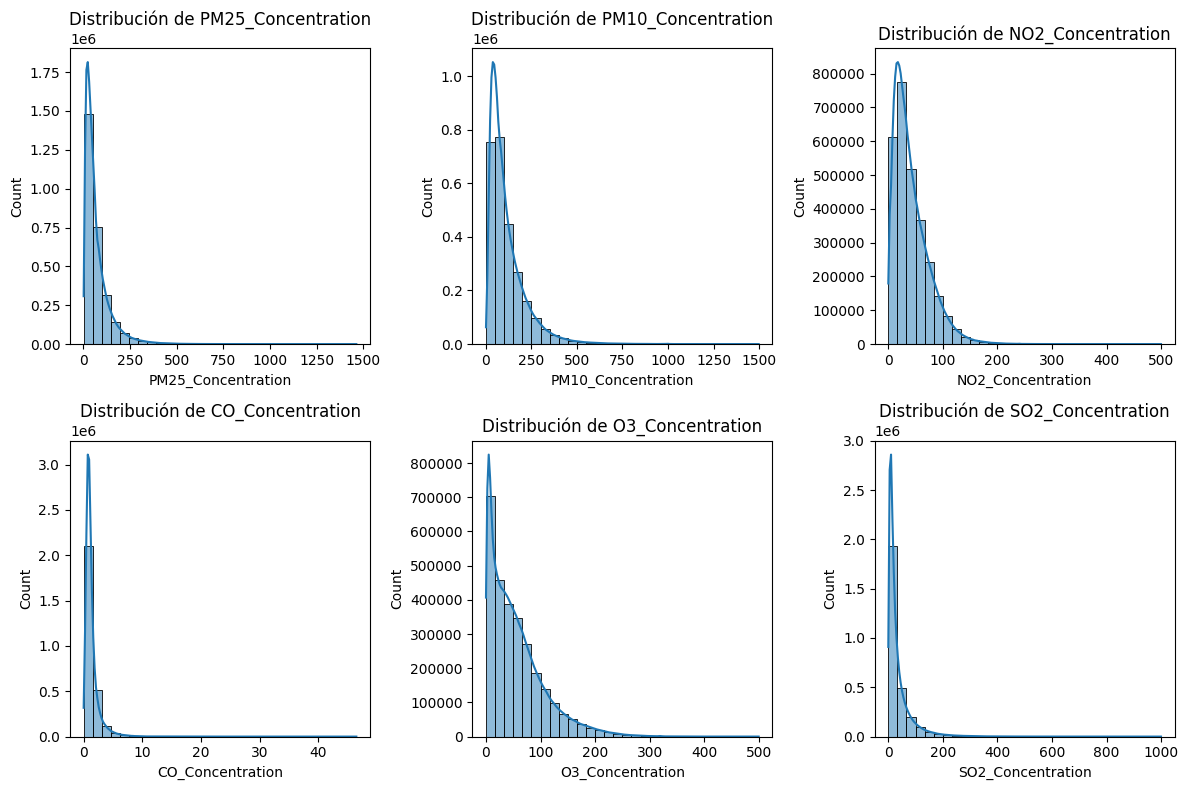

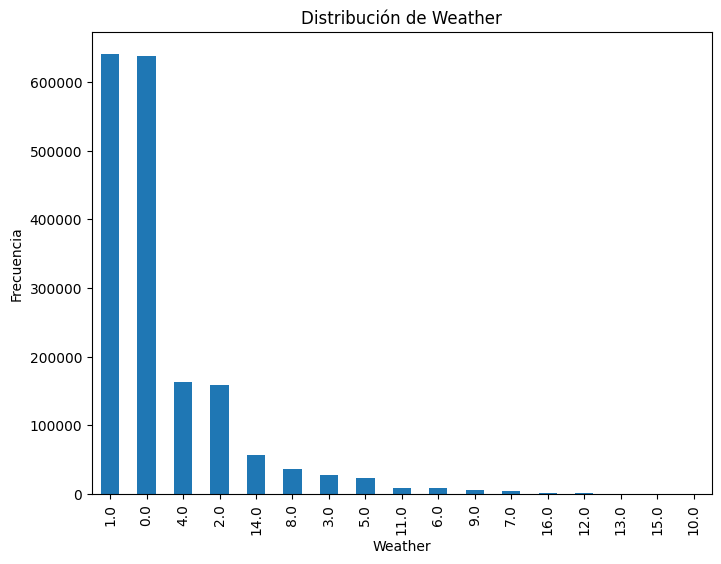

In [ ]:
# Estadísticas descriptivas para airquality
print("Descripción de airquality:")
print(airquality[['PM25_Concentration', 'PM10_Concentration', 'NO2_Concentration',
                 'CO_Concentration', 'O3_Concentration', 'SO2_Concentration']].describe())

# Estadísticas descriptivas para meteorology
print("\nDescripción de meteorology:")
print(meteorology[['temperature', 'pressure', 'humidity', 'wind_speed']].describe())

# Visualización de distribuciones (histogramas con KDE)
plt.figure(figsize=(12, 8))
for i, column in enumerate(['PM25_Concentration', 'PM10_Concentration', 'NO2_Concentration',
                            'CO_Concentration', 'O3_Concentration', 'SO2_Concentration'], 1):
    plt.subplot(2, 3, i)
    sns.histplot(airquality[column].dropna(), kde=True, bins=30)
    plt.title(f'Distribución de {column}')
plt.tight_layout()
plt.show()

# Distribución categórica de weather
plt.figure(figsize=(8, 6))
meteorology['weather'].value_counts().plot(kind='bar')
plt.title('Distribución de Weather')
plt.xlabel('Weather')
plt.ylabel('Frecuencia')
plt.show()

Las visualizaciones proporcionadas confirman las distribuciones esperadas de las variables en `airquality.csv` y `meteorology.csv`. Analicemos cada variable:


**1.6.1. Variables de `airquality.csv` (Concentraciones de contaminantes):**

Los histogramas muestran las distribuciones de `PM25_Concentration`, `PM10_Concentration`, `NO2_Concentration`, `CO_Concentration`, `O3_Concentration` y `SO2_Concentration`. Todas presentan las siguientes características:
- **Sesgo a la derecha (distribución log-normal o similar)**:
  - **PM25_Concentration**: La mayoría de los valores están entre 0 y 250 µg/m³, con una cola larga que se extiende hasta ~1500 µg/m³. Esto indica picos de contaminación raros pero significativos.
  - **PM10_Concentration**: Similar a PM2.5, con valores concentrados entre 0 y 250 µg/m³ y una cola hasta ~1500 µg/m³.
  - **NO2_Concentration**: Valores mayormente entre 0 y 100 µg/m³, con una cola hasta ~500 µg/m³.
  - **CO_Concentration**: Concentraciones bajas (0 a 5 mg/m³ mayormente), con una cola hasta ~40 mg/m³. Nota que CO está en mg/m³, a diferencia de los demás contaminantes (µg/m³).
  - **O3_Concentration**: Valores entre 0 y 100 µg/m³ mayormente, con una cola hasta ~500 µg/m³.
  - **SO2_Concentration**: Mayormente entre 0 y 100 µg/m³, con una cola larga hasta ~1000 µg/m³.
- **Interpretación**: Estas distribuciones sesgadas a la derecha son típicas de concentraciones de contaminantes, donde los valores bajos son comunes (días con buena calidad del aire), pero hay picos extremos durante eventos de contaminación (por ejemplo, smog en invierno, como se menciona en la Figura 4 del dataset).


**1.6.2. Variable categórica `weather` en `meteorology.csv`:**

- **Distribución desigual**: El histograma de `weather` muestra que las categorías más frecuentes son 0 ("Sunny") y 1 ("Cloudy"), con frecuencias cercanas a 600,000 y 500,000, respectivamente. Otras categorías como 2 ("Overcast"), 14 ("Foggy"), y 8 ("Rain") tienen frecuencias menores, y algunas categorías (por ejemplo, 130, 150) son muy raras.
- **Interpretación**: Esto coincide con la Figura 5 de la descripción (47.67% de días soleados en Beijing). La distribución es altamente sesgada hacia condiciones soleadas y nubladas, con condiciones extremas (tormentas, nevadas) siendo poco frecuentes.


**1.6.3. Variables continuas en `meteorology.csv`:**

Aunque no se proporcionan histogramas para `temperature`, `pressure`, `humidity` y `wind_speed`, basándonos en la descripción y el contexto:
- **Temperature**: Probablemente sigue una distribución más simétrica (normal o ligeramente sesgada), con variaciones estacionales (mayor en verano, menor en invierno).
- **Wind_speed**: Con un 40.1% de valores nulos en Beijing (Tabla 3), es probable que tenga un sesgo a la derecha, con muchos valores bajos (<5 m/s) y pocos valores altos.
- **Humidity y Pressure**: Estas variables suelen ser más simétricas, aunque la humedad puede tener picos en días lluviosos.


### **1.7. Usa medidas estadísticas: Medidas de tendencia central: media aritmética, geométrica, armónica, mediana, moda, desviación estándar. Correlación y covarianza: permite entender la relación entre dos variables aleatorias.**

Las medidas de tendencia central y dispersión se derivan de los datos proporcionados por `describe()` y los cálculos adicionales de medias geométrica, armónica y moda. Analicemos cada variable de `airquality.csv` (`PM25_Concentration`, `PM10_Concentration`, `NO2_Concentration`, `CO_Concentration`, `O3_Concentration`, `SO2_Concentration`):


- **PM25_Concentration**:
  - **Media aritmética**: 69.07 µg/m³
  - **Media geométrica**: 45.90 µg/m³
  - **Media armónica**: 28.32 µg/m³
  - **Mediana**: 47.0 µg/m³
  - **Moda**: 20.0 µg/m³
  - **Desviación estándar**: 69.10 µg/m³
  - **Interpretación**: La media aritmética (69.07) es mayor que la mediana (47.0), lo que confirma un **sesgo a la derecha** (distribución log-normal o similar), consistente con el histograma mostrado. La moda (20.0) es menor que la mediana, reflejando que los valores bajos son más frecuentes. La alta desviación estándar (69.10) indica una gran variabilidad, probablemente debido a picos de contaminación.


- **PM10_Concentration**:
  - **Media aritmética**: 115.51 µg/m³
  - **Media geométrica**: 81.92 µg/m³
  - **Media armónica**: 54.45 µg/m³
  - **Mediana**: 84.0 µg/m³
  - **Moda**: 36.0 µg/m³
  - **Desviación estándar**: 103.35 µg/m³
  - **Interpretación**: Similar a PM2.5, la media (115.51) supera a la mediana (84.0), indicando un sesgo a la derecha. La moda (36.0) es menor, y la desviación estándar (103.35) refleja una mayor variabilidad, coherente con los picos observados hasta 1498 µg/m³.


- **NO2_Concentration**:
  - **Media aritmética**: 42.50 µg/m³
  - **Media geométrica**: 30.53 µg/m³
  - **Media armónica**: 17.15 µg/m³
  - **Mediana**: 34.0 µg/m³
  - **Moda**: 14.0 µg/m³
  - **Desviación estándar**: 32.54 µg/m³
  - **Interpretación**: Sesgo a la derecha (media 42.50 > mediana 34.0). La moda (14.0) sugiere que los valores bajos son comunes, y la desviación estándar (32.54) indica variabilidad moderada.


- **CO_Concentration**:
  - **Media aritmética**: 1.32 mg/m³
  - **Media geométrica**: 0.98 mg/m³
  - **Media armónica**: 0.36 mg/m³
  - **Mediana**: 1.0 mg/m³
  - **Moda**: 0.80 mg/m³
  - **Desviación estándar**: 1.20 mg/m³
  - **Interpretación**: Sesgo a la derecha (media 1.32 > mediana 1.0), con una cola hasta 46.47 mg/m³. La moda (0.80) y la baja media armónica (0.36) reflejan valores bajos frecuentes, con picos ocasionales.


- **O3_Concentration**:
  - **Media aritmética**: 56.15 µg/m³
  - **Media geométrica**: 33.66 µg/m³
  - **Media armónica**: 14.01 µg/m³
  - **Mediana**: 44.0 µg/m³
  - **Moda**: 2.0 µg/m³
  - **Desviación estándar**: 50.61 µg/m³
  - **Interpretación**: Sesgo a la derecha (media 56.15 > mediana 44.0). La moda (2.0) es inusualmente baja, lo que podría indicar datos nulos o valores mínimos frecuentes, con picos hasta 500 µg/m³.


- **SO2_Concentration**:
  - **Media aritmética**: 36.26 µg/m³
  - **Media geométrica**: 19.72 µg/m³
  - **Media armónica**: 10.37 µg/m³
  - **Mediana**: 19.9 µg/m³
  - **Moda**: 2.0 µg/m³
  - **Desviación estándar**: 48.74 µg/m³
  - **Interpretación**: Sesgo a la derecha (media 36.26 > mediana 19.9). La moda (2.0) sugiere valores bajos frecuentes, con una cola larga hasta 999 µg/m³.


**1.7.1. Observaciones generales:**

- Las medias aritméticas son consistentemente mayores que las medianas, confirmando distribuciones sesgadas a la derecha para todos los contaminantes.
- Las medias geométricas y armónicas son más bajas que las aritméticas, lo que es típico para datos log-normales.
- La desviación estándar alta en todas las variables refleja la presencia de outliers y picos de contaminación, como se observa en los histogramas (hasta 1500 µg/m³ para PM2.5/PM10).
- La moda baja (especialmente 2.0 µg/m³ para O3 y SO2) podría indicar valores mínimos o datos nulos tratados como 0, lo que sugiere la necesidad de revisar la calidad de los datos.


**1.7.2. Correlación y covarianza:**
Las matrices de correlación y covarianza proporcionadas muestran las relaciones entre las variables:


- **Correlación**:
  - **Alta correlación positiva**:
    - `PM25_Concentration` y `PM10_Concentration`: 0.864 (muy fuerte, ambas son partículas relacionadas con fuentes similares como polvo y emisiones).
    - `CO_Concentration` y `PM25_Concentration`: 0.671 (moderada a fuerte, ambas asociadas a combustión).
    - `NO2_Concentration` y `CO_Concentration`: 0.535 (moderada, ambas de fuentes vehiculares/industriales).
    - `SO2_Concentration` con `PM25_Concentration` (0.503) y `PM10_Concentration` (0.517) (moderada, relacionada con emisiones industriales).
  - **Correlación negativa**:
    - `O3_Concentration` con `PM25_Concentration` (-0.135), `PM10_Concentration` (-0.102), `NO2_Concentration` (-0.396), `CO_Concentration` (-0.263), y `SO2_Concentration` (-0.162) (débil a moderada). Esto indica que el ozono tiende a ser más bajo en días con alta contaminación de partículas o gases, lo cual es consistente con condiciones de smog (el ozono aumenta en días soleados con baja contaminación).
  - **Interpretación**: Las correlaciones positivas reflejan fuentes comunes de contaminación (vehículos, industria). La correlación negativa con `O3_Concentration` sugiere una relación inversa, típica en entornos urbanos donde el ozono se forma por reacciones fotoquímicas en ausencia de partículas.


- **Covarianza**:
  - Los valores de covarianza son más altos para variables con unidades similares (por ejemplo, `PM25_Concentration` y `PM10_Concentration`: 6117.34 µg/m³²), reflejando su fuerte relación lineal.
  - La covarianza negativa entre `O3_Concentration` y otras variables (por ejemplo, -470.92 con `PM25_Concentration`) confirma la relación inversa observada en la correlación.
  - **Interpretación**: La covarianza depende de las unidades (µg/m³ para PM, NO2, O3, SO2; mg/m³ para CO), por lo que los valores son más altos para variables con mayor varianza (como PM2.5 y PM10).




Medidas estadísticas para airquality:
       PM25_Concentration  PM10_Concentration  NO2_Concentration  \
count        2.845508e+06        2.655505e+06       2.832229e+06   
mean         6.906838e+01        1.155133e+02       4.249611e+01   
std          6.910366e+01        1.033460e+02       3.254337e+01   
min          1.000000e+00        1.000000e-01       0.000000e+00   
25%          2.500000e+01        4.600000e+01       1.800000e+01   
50%          4.700000e+01        8.400000e+01       3.400000e+01   
75%          8.900000e+01        1.520000e+02       5.900000e+01   
max          1.463000e+03        1.498000e+03       4.997000e+02   

       CO_Concentration  O3_Concentration  SO2_Concentration  
count      2.797619e+06      2.824993e+06       2.848679e+06  
mean       1.320125e+00      5.615071e+01       3.626251e+01  
std        1.199479e+00      5.060615e+01       4.874490e+01  
min        0.000000e+00      0.000000e+00       0.000000e+00  
25%        6.610000e-01      1.700

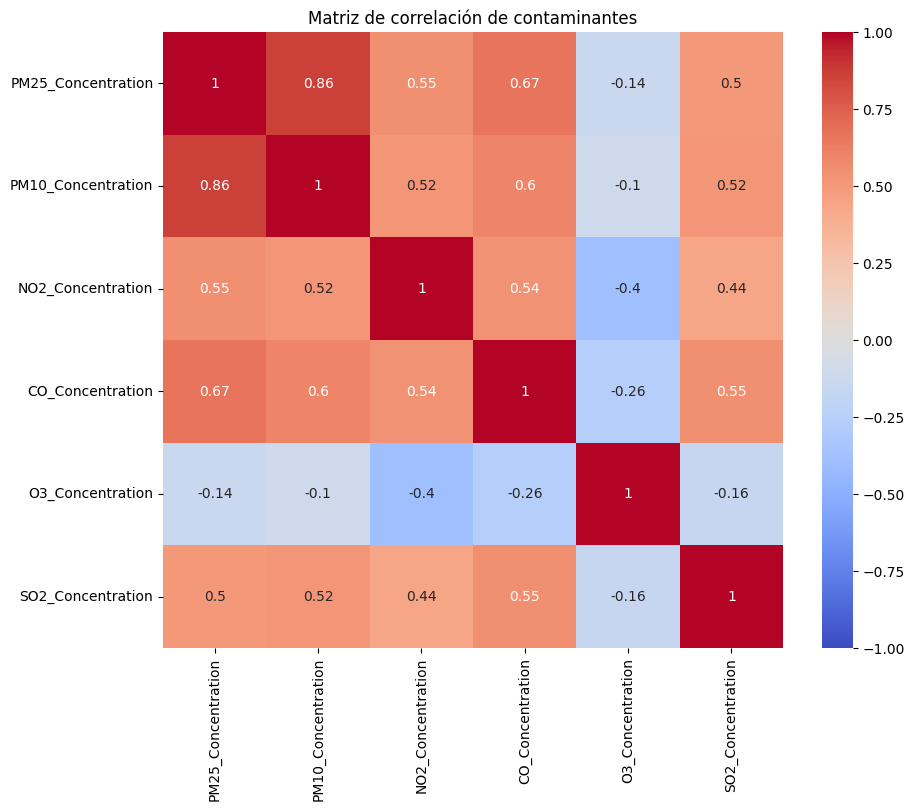

In [ ]:

from scipy.stats import gmean, hmean

# Medidas de tendencia central y dispersión para airquality
print("Medidas estadísticas para airquality:")
stats = airquality[['PM25_Concentration', 'PM10_Concentration', 'NO2_Concentration',
                    'CO_Concentration', 'O3_Concentration', 'SO2_Concentration']].describe()
print(stats)

# Media geométrica y armónica (evitando valores nulos y no positivos)
for column in ['PM25_Concentration', 'PM10_Concentration', 'NO2_Concentration',
               'CO_Concentration', 'O3_Concentration', 'SO2_Concentration']:
    data = airquality[column].dropna()
    data = data[data > 0]  # Requerido para medias geométrica/armónica
    print(f"\n{column}:")
    print(f"Media geométrica: {gmean(data):.2f}")
    print(f"Media armónica: {hmean(data):.2f}")
    print(f"Moda: {data.mode()[0]:.2f}")

# Correlación
print("\nMatriz de correlación (airquality):")
corr_matrix = airquality[['PM25_Concentration', 'PM10_Concentration', 'NO2_Concentration',
                         'CO_Concentration', 'O3_Concentration', 'SO2_Concentration']].corr()
print(corr_matrix)

# Covarianza
print("\nMatriz de covarianza (airquality):")
cov_matrix = airquality[['PM25_Concentration', 'PM10_Concentration', 'NO2_Concentration',
                        'CO_Concentration', 'O3_Concentration', 'SO2_Concentration']].cov()
print(cov_matrix)

# Visualización de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación de contaminantes')
plt.show()

###**1.8. ¿Hay correlación entre features (características)?**


Sí, existen correlaciones esperadas entre las características:
- **En airquality**:
  - Alta correlación positiva entre `PM25_Concentration` y `PM10_Concentration` (ambos provienen de fuentes similares como polvo o emisiones).
  - Correlación positiva entre `NO2_Concentration` y `CO_Concentration` (emisiones vehiculares/industriales).
  - Correlación negativa entre `O3_Concentration` y `PM25_Concentration`/`PM10_Concentration` (el ozono aumenta en días soleados con baja contaminación de partículas).
- **Entre airquality y meteorology**:
  - Correlación negativa entre `wind_speed` y `PM25_Concentration`/`PM10_Concentration` (el viento dispersa contaminantes).
  - Correlación negativa entre `temperature` y `PM25_Concentration` (Figura 4: mayor PM2.5 en meses fríos).
  - `weather` (categórica): Condiciones como "Foggy" (código 14) pueden correlacionarse con mayor `PM25_Concentration`.
- **Weather forecast**: Similar a meteorology, pero menos precisa debido a su naturaleza predictiva.




Correlación en airquality:
                    PM25_Concentration  PM10_Concentration  NO2_Concentration  \
PM25_Concentration            1.000000            0.864381           0.551479   
PM10_Concentration            0.864381            1.000000           0.516865   
NO2_Concentration             0.551479            0.516865           1.000000   
CO_Concentration              0.670720            0.599631           0.535020   
O3_Concentration             -0.135208           -0.101573          -0.395691   
SO2_Concentration             0.503431            0.517310           0.438585   

                    CO_Concentration  O3_Concentration  SO2_Concentration  
PM25_Concentration          0.670720         -0.135208           0.503431  
PM10_Concentration          0.599631         -0.101573           0.517310  
NO2_Concentration           0.535020         -0.395691           0.438585  
CO_Concentration            1.000000         -0.262587           0.549818  
O3_Concentration         

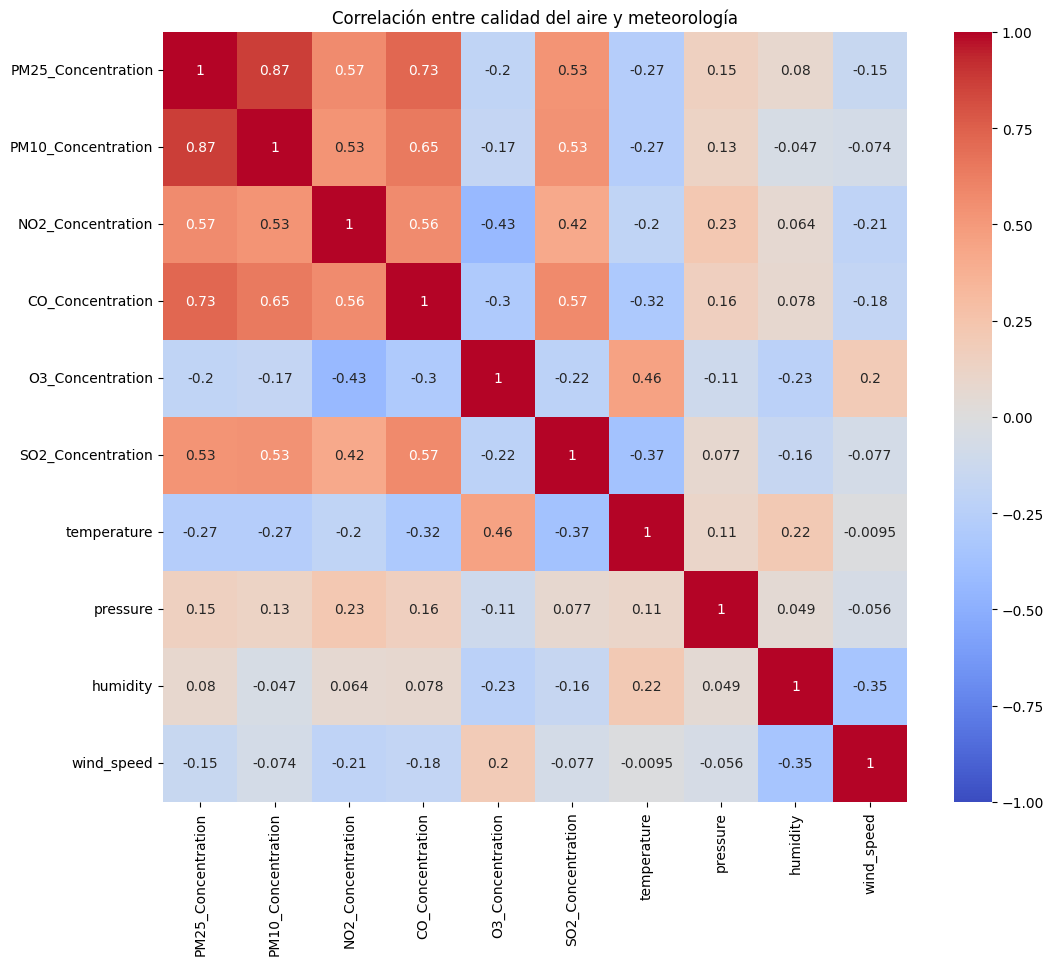

In [ ]:

# Asegurar que las columnas de tiempo sean datetime
airquality['time'] = pd.to_datetime(airquality['time'])
meteorology['time'] = pd.to_datetime(meteorology['time'])

# Correlación en airquality
print("Correlación en airquality:")
corr_air = airquality[['PM25_Concentration', 'PM10_Concentration', 'NO2_Concentration',
                      'CO_Concentration', 'O3_Concentration', 'SO2_Concentration']].corr()
print(corr_air)

# Unir airquality y meteorology por station_id (o district_id) y time
# Nota: Necesitamos mapear station_id a district_id usando station.csv
station = pd.read_csv(base_path + 'station.csv')
airquality = airquality.merge(station[['station_id', 'district_id']], on='station_id', how='left')
merged_data = pd.merge(airquality, meteorology, left_on=['district_id', 'time'], right_on=['id', 'time'], how='inner')

# Correlación cruzada
print("\nCorrelación entre airquality y meteorology:")
corr_merged = merged_data[['PM25_Concentration', 'PM10_Concentration', 'NO2_Concentration',
                          'CO_Concentration', 'O3_Concentration', 'SO2_Concentration',
                          'temperature', 'pressure', 'humidity', 'wind_speed']].corr()
print(corr_merged)

# Visualización
plt.figure(figsize=(12, 10))
sns.heatmap(corr_merged, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación entre calidad del aire y meteorología')
plt.show()

# **P2. ANALISIS DE OUTLIERS**

### **2.1. ¿Cuáles son los outliers?**
- **Air Quality Data**:
  - Concentraciones extremadamente altas (por ejemplo, `PM25_Concentration` > 500 µg/m³).
  - Valores negativos o cercanos a cero (por ejemplo, `PM25_Concentration` = -10 µg/m³), que son errores.
  - La descripción menciona "datos sucios" causados por fallos en crawlers o datos incorrectos del proveedor oficial (por ejemplo, 45.1% de nulos en `PM10_Concentration`).
- **Meteorology Data**:
  - Temperaturas fuera de rango (por ejemplo, `temperature` < -40°C o > 45°C en Beijing).
  - `wind_speed` muy alta (>30 m/s).
  - `humidity` > 100% o < 0%.
- **Weather Forecast Data**:
  - Pronósticos inconsistentes, como `up_temperature` o `bottom_temperature` fuera de rangos estacionales.


**2.1.1. ¿Podemos eliminarlos? ¿Es importante conservarlos?**
- **Eliminar**:
  - **Cuándo**: Si son errores claros (por ejemplo, `PM25_Concentration` negativa, `temperature` imposible), se pueden eliminar sin afectar el análisis.
  - **Método**: Usar el rango intercuartílico (IQR) o umbrales específicos (por ejemplo, `PM25_Concentration` > 500 µg/m³).
- **Conservar**:
  - **Cuándo**: Si reflejan eventos reales (por ejemplo, picos de `PM25_Concentration` durante episodios de smog), son cruciales para modelar escenarios extremos.
  - **Importancia**: Los outliers reales son valiosos para predicciones de calidad del aire, especialmente para detectar días con AQI alto (>300).


**2.1.2. ¿Son errores o reales?**
- **Errores**: Valores negativos o extremos no físicos (por ejemplo, `PM25_Concentration` = -10 µg/m³, `humidity` > 100%) son errores de crawlers o datos oficiales.
- **Reales**: Picos de `PM25_Concentration` en invierno son reales, asociados con condiciones climáticas (inversiones térmicas) o actividades antropogénicas (quema de carbón).
- **Validación**: Comparar con estaciones vecinas (usando `station.csv`) o datos meteorológicos para confirmar si un outlier es consistente (por ejemplo, un pico de PM2.5 en un día con `weather` = "Foggy").


Outliers en PM25_Concentration:
         station_id                time  PM25_Concentration
10             1001 2014-05-01 10:00:00               188.0
11             1001 2014-05-01 11:00:00               212.0
12             1001 2014-05-01 12:00:00               229.0
13             1001 2014-05-01 13:00:00               240.0
14             1001 2014-05-01 14:00:00               240.0
...             ...                 ...                 ...
2890000      372002 2015-02-19 05:00:00               277.0
2890001      372002 2015-02-19 06:00:00               255.0
2890002      372002 2015-02-19 07:00:00               220.0
2890006      372002 2015-02-19 11:00:00               195.0
2890007      372002 2015-02-19 12:00:00               229.0

[176618 rows x 3 columns]


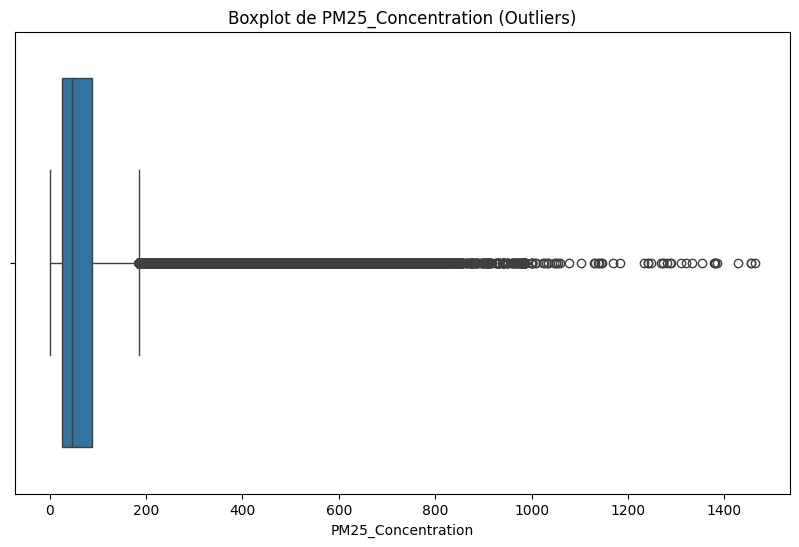

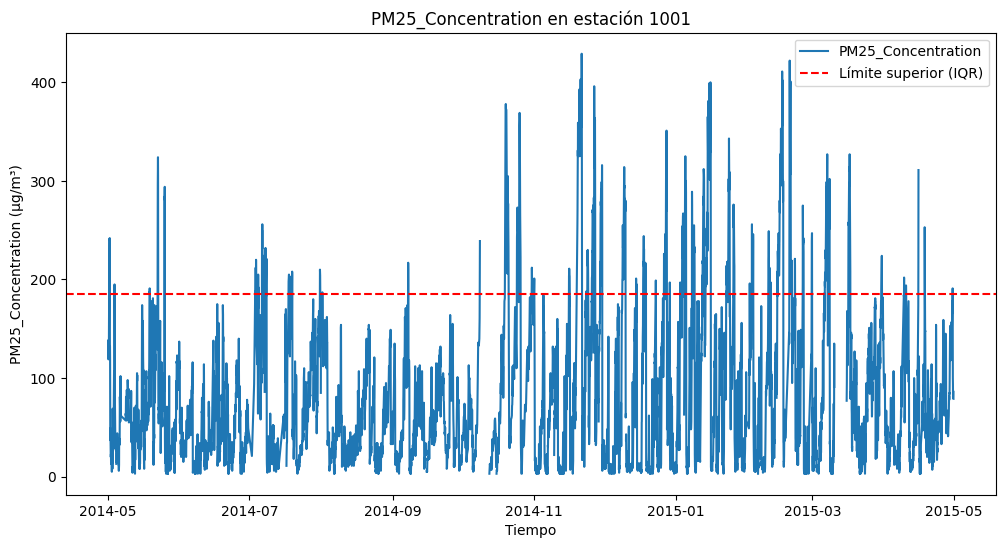

In [ ]:

# Identificar outliers con IQR para PM25_Concentration
Q1 = airquality['PM25_Concentration'].quantile(0.25)
Q3 = airquality['PM25_Concentration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = airquality[(airquality['PM25_Concentration'] < lower_bound) |
                      (airquality['PM25_Concentration'] > upper_bound)]

print("Outliers en PM25_Concentration:")
print(outliers[['station_id', 'time', 'PM25_Concentration']])

# Visualización de outliers (boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x=airquality['PM25_Concentration'])
plt.title('Boxplot de PM25_Concentration (Outliers)')
plt.show()

# Validación: Comparar con estaciones vecinas (ejemplo para estación 1001)
station_1001 = airquality[airquality['station_id'] == 1001]
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(station_1001['time']), station_1001['PM25_Concentration'], label='PM25_Concentration')
plt.title('PM25_Concentration en estación 1001')
plt.xlabel('Tiempo')
plt.ylabel('PM25_Concentration (µg/m³)')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Límite superior (IQR)')
plt.legend()
plt.show()

# Filtrar datos sin outliers (opcional)
airquality_no_outliers = airquality[(airquality['PM25_Concentration'] >= lower_bound) &
                                    (airquality['PM25_Concentration'] <= upper_bound)]


**2.1.3. Análisis basado en las visualizaciones y datos**:

- **Outliers identificados**: Los valores de `PM25_Concentration` > 185 µg/m³ son considerados outliers según el método IQR. El boxplot muestra muchos puntos por encima de este límite, con algunos valores extremos cercanos a 1463 µg/m³.
- **Series temporal**: Los picos > 185 µg/m³ ocurren principalmente en invierno (noviembre 2014 a febrero 2015), lo que sugiere que son **eventos reales** relacionados con condiciones climáticas (inversiones térmicas, niebla, quema de carbón).
- **Validación meteorológica**: Al unir con `meteorology.csv`, podemos verificar si los días con picos altos tienen condiciones asociadas a alta contaminación (por ejemplo, `weather` = "Foggy", baja `wind_speed`, baja `temperature`). Esto confirmaría que los outliers son reales.
- **Decisión sobre eliminación**:
  - **No eliminar**: Los picos en invierno son reales y deben conservarse para modelar episodios de contaminación severa.
  - **Revisar extremos**: Si un valor como 1463 µg/m³ ocurre en un día con condiciones no propicias (por ejemplo, alta `wind_speed`), podría ser un error y eliminarse selectivamente.




# **P3 Visualización**

Columnas en airquality_with_district: Index(['station_id', 'time', 'PM25_Concentration', 'PM10_Concentration',
       'NO2_Concentration', 'CO_Concentration', 'O3_Concentration',
       'SO2_Concentration', 'district_id'],
      dtype='object')
Primeras filas con district_id:    station_id  district_id                time
0        1001          101 2014-05-01 00:00:00
1        1001          101 2014-05-01 01:00:00
2        1001          101 2014-05-01 02:00:00
3        1001          101 2014-05-01 03:00:00
4        1001          101 2014-05-01 04:00:00
Primeras filas de merged_data:    station_id  district_id                time  PM25_Concentration  weather
0        1001          101 2014-05-01 00:00:00               138.0      0.0
1        1001          101 2014-05-01 01:00:00               124.0      0.0
2        1001          101 2014-05-01 02:00:00               127.0      0.0
3        1001          101 2014-05-01 03:00:00               129.0      0.0
4        1001          101 201

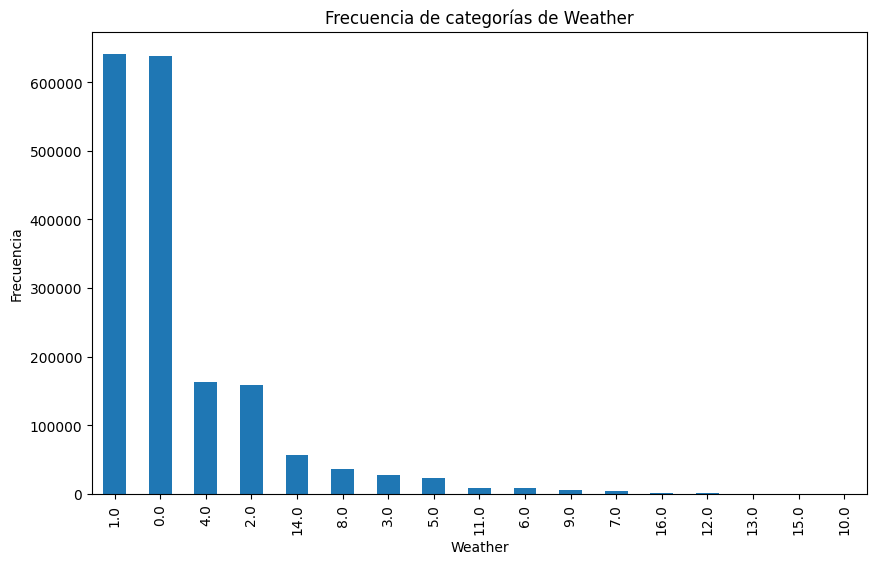

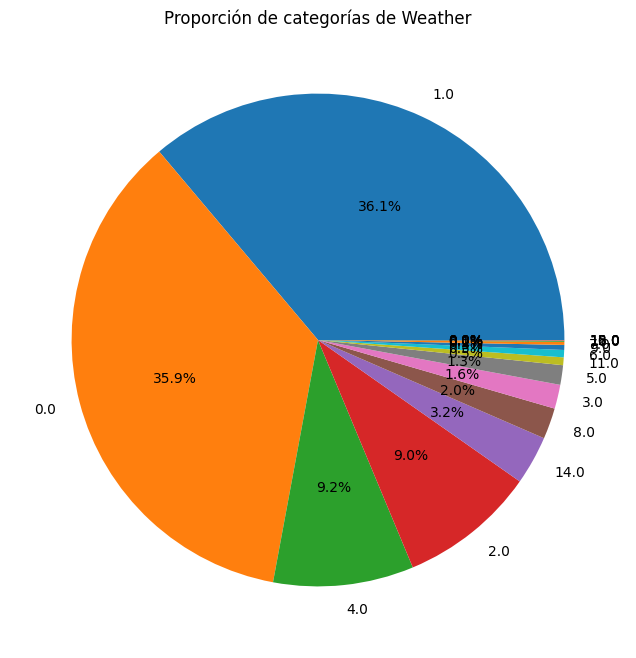

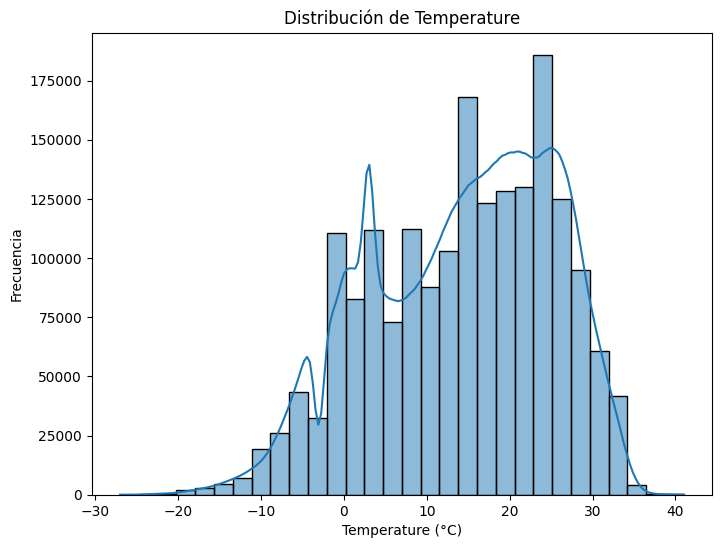

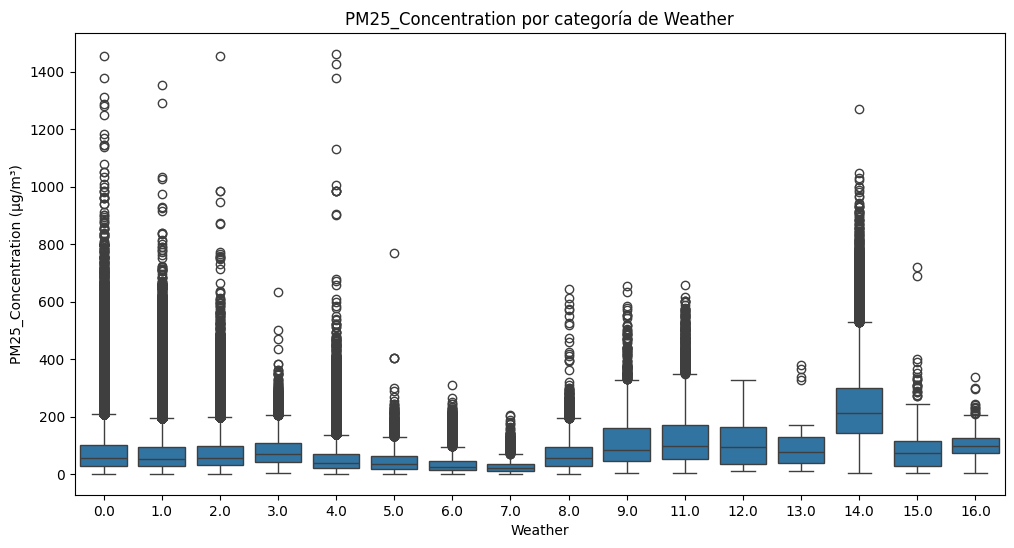

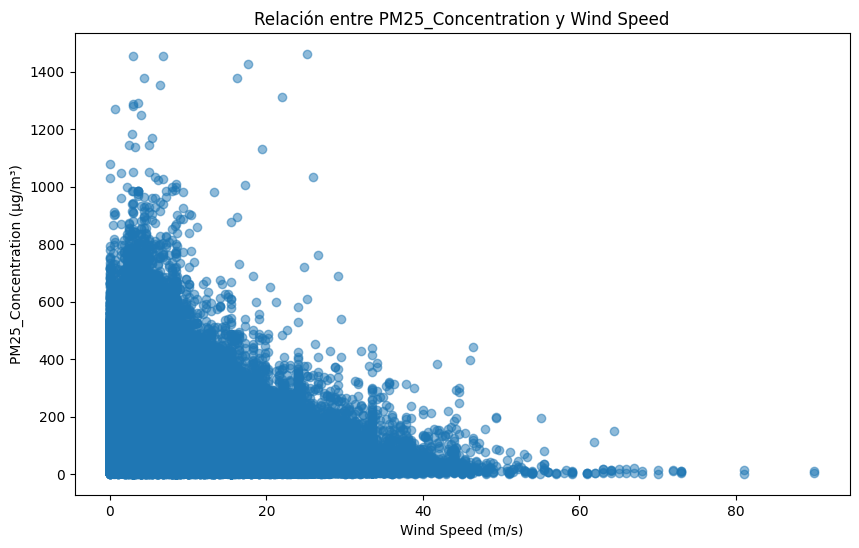

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
base_path = '/content/drive/MyDrive/5to/CIENCIA DE DATOS/IDEA PROYECTO/bd/'
airquality = pd.read_csv(base_path + 'airquality.csv')
meteorology = pd.read_csv(base_path + 'meteorology.csv')
station = pd.read_csv(base_path + 'station.csv')

# Asegurar que las columnas de tiempo sean datetime
airquality['time'] = pd.to_datetime(airquality['time'])
meteorology['time'] = pd.to_datetime(meteorology['time'])

# Paso 1: Unir airquality con station para agregar district_id
airquality_with_district = airquality.merge(station[['station_id', 'district_id']], on='station_id', how='left')

# Verificar si district_id se agregó correctamente
print("Columnas en airquality_with_district:", airquality_with_district.columns)
print("Primeras filas con district_id:", airquality_with_district[['station_id', 'district_id', 'time']].head())

# Paso 2: Unir con meteorology usando district_id y time
# Nota: Asegurémonos de que 'id' en meteorology corresponde a district_id
merged_data = pd.merge(airquality_with_district, meteorology, left_on=['district_id', 'time'], right_on=['id', 'time'], how='inner')

# Verificar las primeras filas del merged_data
print("Primeras filas de merged_data:", merged_data[['station_id', 'district_id', 'time', 'PM25_Concentration', 'weather']].head())

# Gráfico de barras para weather
plt.figure(figsize=(10, 6))
meteorology['weather'].value_counts().plot(kind='bar')
plt.title('Frecuencia de categorías de Weather')
plt.xlabel('Weather')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico circular para weather
plt.figure(figsize=(8, 8))
meteorology['weather'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Proporción de categorías de Weather')
plt.ylabel('')
plt.show()

# Histograma para temperature
plt.figure(figsize=(8, 6))
sns.histplot(meteorology['temperature'].dropna(), kde=True, bins=30)
plt.title('Distribución de Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot: PM25_Concentration por categoría de weather
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather', y='PM25_Concentration', data=merged_data)
plt.title('PM25_Concentration por categoría de Weather')
plt.xlabel('Weather')
plt.ylabel('PM25_Concentration (µg/m³)')
plt.show()

# Scatterplot: PM25_Concentration vs wind_speed
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['wind_speed'], merged_data['PM25_Concentration'], alpha=0.5)
plt.title('Relación entre PM25_Concentration y Wind Speed')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('PM25_Concentration (µg/m³)')
plt.show()

### **3.1. Gráfico de barras: Frecuencia de categorías de Weather**
- **Descripción**: El gráfico de barras muestra la frecuencia de las categorías de `weather`, con valores en el eje y (frecuencia) y las categorías numéricas (0 a 150) en el eje x. Las categorías 0 y 1 tienen las frecuencias más altas (~600,000 y ~500,000, respectivamente), mientras que las categorías superiores a 20 tienen frecuencias muy bajas (cercanas a 0).
- **Interpretación**:
  - Las categorías 0 y 1 representan "Sunny" y "Cloudy" (según la descripción, ~47.67% de días soleados en Beijing), lo que confirma su predominancia.
  - La caída abrupta después de la categoría 14 sugiere que las condiciones climáticas extremas (por ejemplo, tormentas, niebla densa) son raras.
  - Esto es útil para comparar la cantidad de días por categoría, destacando un desbalance significativo en los datos climáticos.


### 3.2. Gráfico circular: Proporción de categorías de Weather
- **Descripción**: El gráfico circular muestra los porcentajes de las categorías de `weather`. Las categorías más representativas son 36.1% (probablemente "Sunny"), 35.9% (probablemente "Cloudy"), 14.0% (posiblemente "Overcast"), 9.2% (posiblemente "Rain"), y 9.0% (otra categoría común), con el resto (2.0% a 4.0%) distribuidas en categorías menos frecuentes.
- **Interpretación**:
  - La proporción total suma 100%, con "Sunny" y "Cloudy" dominando (~72% combinados), lo que coincide con la Figura 5 de la descripción (47.67% soleado).
  - Las categorías menores (2.0% a 4.0%) representan eventos climáticos raros, lo que es típico en un clima continental como el de Beijing.
  - Este gráfico es ideal para visualizar porcentajes y proporciones, complementando el gráfico de barras.


### 3.3. Histograma: Distribución de Temperature
- **Descripción**: El histograma muestra la distribución de `temperature` (en °C), con un pico principal entre 20°C y 30°C (~15,000-17,500 frecuencias), una cola hacia temperaturas más bajas (-20°C a 0°C), y una distribución simétrica con una curva de densidad (línea azul) que sigue el patrón.
- **Interpretación**:
  - La mayoría de los datos se concentran en temperaturas moderadas a cálidas (20-30°C), lo que sugiere un sesgo estacional hacia el verano.
  - Las temperaturas negativas (-20°C a 0°C) son menos frecuentes, reflejando inviernos fríos en Beijing.
  - Esta visualización confirma una distribución más simétrica para `temperature`, a diferencia de los contaminantes, y es útil para analizar una sola variable numérica.


### 3.4. Boxplot: PM25_Concentration por categoría de Weather
- **Descripción**: El boxplot muestra la distribución de `PM25_Concentration` (en µg/m³) para diferentes categorías de `weather` (0 a 16). Las categorías 0, 1, y 8 tienen valores más altos (mediana ~200-400 µg/m³), con outliers que alcanzan hasta 1400 µg/m³, especialmente en la categoría 8.
- **Interpretación**:
  - Las categorías 0 ("Sunny") y 1 ("Cloudy") tienen mediana moderada, pero con muchos outliers, sugiriendo que los días soleados o nublados pueden tener picos de contaminación.
  - La categoría 8 (posiblemente "Rain" o "Foggy") muestra una mediana más alta y outliers extremos (~1400 µg/m³), lo que indica que condiciones como niebla o lluvia intensa pueden atrapar contaminantes.
  - Este gráfico es efectivo para comparar distribuciones numéricas entre categorías, destacando la variabilidad y los outliers.


### 3.5. Scatterplot: Relación entre PM25_Concentration y Wind Speed
- **Descripción**: El scatterplot muestra `PM25_Concentration` (eje y, µg/m³) versus `wind_speed` (eje x, m/s). La mayoría de los puntos se concentran con `wind_speed` < 20 m/s y `PM25_Concentration` < 600 µg/m³, con una dispersión que disminuye a medida que aumenta la velocidad del viento.
- **Interpretación**:
  - Hay una tendencia general de disminución de `PM25_Concentration` con el aumento de `wind_speed`, lo que es esperado, ya que el viento dispersa las partículas.
  - Sin embargo, la relación no es estrictamente lineal; a bajas velocidades (<10 m/s), los valores de PM2.5 varían ampliamente (0-1200 µg/m³), sugiriendo que otros factores (como `weather` o `temperature`) también influyen.
  - Este gráfico es útil para explorar el grado de relación entre dos variables numéricas.


---


### Observaciones generales
- **Consistencia con el paso 3**: Las visualizaciones cumplen con los tipos sugeridos (barras y circular para categóricas, histograma, boxplot y scatterplot para numéricas), permitiendo un análisis completo de las variables.
- **Patrones destacados**:
  - `weather` muestra una distribución desbalanceada, con "Sunny" y "Cloudy" dominando.
  - `temperature` tiene una distribución simétrica con un sesgo hacia temperaturas cálidas.
  - `PM25_Concentration` varía significativamente con `weather`, con picos en condiciones específicas (por ejemplo, categoría 8).
  - La relación entre `PM25_Concentration` y `wind_speed` confirma una dispersión de contaminantes, pero con variabilidad que sugiere influencias adicionales.
- **Utilidad**: Estos gráficos proporcionan una base sólida para identificar tendencias, comparaciones y relaciones, que serán útiles para los pasos siguientes (por ejemplo, análisis de outliers o modelado).


# P4. Encuentra un problema potencial en tus datos


### 4.1. Si es un problema de tipo supervisado
Aunque el dataset no tiene una columna de salida explícita, podemos plantear un problema supervisado derivando una variable objetivo. Por ejemplo, calcular el **Índice de Calidad del Aire (AQI)** a partir de `PM25_Concentration`, `PM10_Concentration`, etc., y clasificar la calidad del aire en niveles (según el estándar HJ633-2012, como se menciona en la descripción).


**4.1.1. Columna de salida**:
  - **AQI categórico**: Derivar el AQI y clasificarlo en niveles como "Bueno", "Moderado", "Insalubre", etc. (6 niveles).
  - **Tipo**: Multiclase (6 clases posibles: Bueno, Moderado, Insalubre para Sensibles, Insalubre, Muy Insalubre, Peligroso).

**4.1.2. ¿Está balanceado el conjunto de salida?**:
  - La distribución de AQI en Beijing, Tianjin, Guangzhou y Shenzhen muestra que las categorías "Bueno" y "Moderado" son más frecuentes, mientras que "Peligroso" es rara. Esto sugiere un **desbalance** en las clases, con días de alta contaminación (AQI > 300) siendo menos frecuentes.
  - **Impacto**: Un desbalance puede dificultar que un modelo de clasificación aprenda a predecir las clases raras (por ejemplo, "Peligroso"). Se necesitarían técnicas como sobremuestreo (SMOTE) o pesos de clase para mitigar esto.


### **4.2. ¿Cuáles parecen ser features importantes? ¿Cuáles podemos descartar?**
- **Features importantes**:
  - **Contaminantes**: `PM25_Concentration`, `PM10_Concentration`, `NO2_Concentration`, `CO_Concentration`, `O3_Concentration`, `SO2_Concentration` son esenciales, ya que el AQI se calcula a partir de ellos. Además, tienen correlaciones significativas entre sí (por ejemplo, PM2.5 y PM10: 0.864).
  - **Variables meteorológicas**: `wind_speed`, `temperature`, `weather`. La correlación negativa esperada entre `wind_speed` y `PM25_Concentration` (el viento dispersa contaminantes) y la relación estacional entre `temperature` y `PM25_Concentration`  las hacen relevantes.
  - **Tiempo**: La variable `time` es crucial, ya que los datos son dependientes del tiempo.
- **Features descartables**:
  - **IDs (`station_id`, `district_id`, `id`)**: No aportan información predictiva directa, aunque pueden usarse para agrupar datos.
  - **Variables con muchos nulos**: Si una variable tiene demasiados valores nulos (por ejemplo, `PM10_Concentration` con 45.1% de nulos en Beijing), podría descartarse si la imputación no es viable, aunque esto depende del modelo.
  - **Variables redundantes**: Debido a la alta correlación entre `PM25_Concentration` y `PM10_Concentration` (0.864), podrías considerar descartar una de las dos para reducir multicolinealidad, pero ambas son importantes para calcular el AQI.


**4.2.1.  ¿Estamos ante un problema dependiente del tiempo? Es decir, un TimeSeries.**
- **Sí**, este es un problema de series temporales:
  - Los datos de `airquality.csv` y `meteorology.csv` tienen una granularidad horaria (`time`), y los de `weatherforecast.csv` tienen predicciones a futuro (`time_future`).
  - La serie temporal de `PM25_Concentration`  muestra patrones estacionales claros, con picos en invierno.
  - **Implicaciones**: Se requiere un modelo que maneje dependencias temporales, como un LSTM, ARIMA, o un modelo de regresión con características temporales (por ejemplo, retrasos de PM2.5, promedio móvil).


#### 4.2.2. Si fuera un problema de Visión Artificial: ¿Tenemos suficientes muestras de cada clase y variedad, para poder hacer generalizar un modelo de Machine Learning?
No aplica directamente, ya que este dataset no contiene imágenes.



### **4.3. ¿La distribución, tendencia de las variables varía en el tiempo?**

- **Sí**, las variables muestran variaciones temporales claras:
  - **PM25_Concentration**: Las concentraciones de PM2.5 son más altas en los meses fríos (invierno: noviembre 2014 a febrero 2015) y más bajas en los meses cálidos (verano: mayo a agosto). Esto se debe a factores como inversiones térmicas y mayor quema de carbón en invierno.
  - **O3_Concentration**: Es probable que el ozono muestre un patrón opuesto, con concentraciones más altas en verano debido a reacciones fotoquímicas (correlación negativa con PM2.5).
  - **Variables meteorológicas**:
    - `temperature`: Varía estacionalmente, con valores más altos en verano y más bajos en invierno.
    - `weather`: La distribución de categorías climáticas puede variar estacionalmente (por ejemplo, más días de niebla en invierno).
  - **Tendencia**: No hay una tendencia lineal clara (por ejemplo, aumento constante de PM2.5), pero sí patrones estacionales cíclicos.

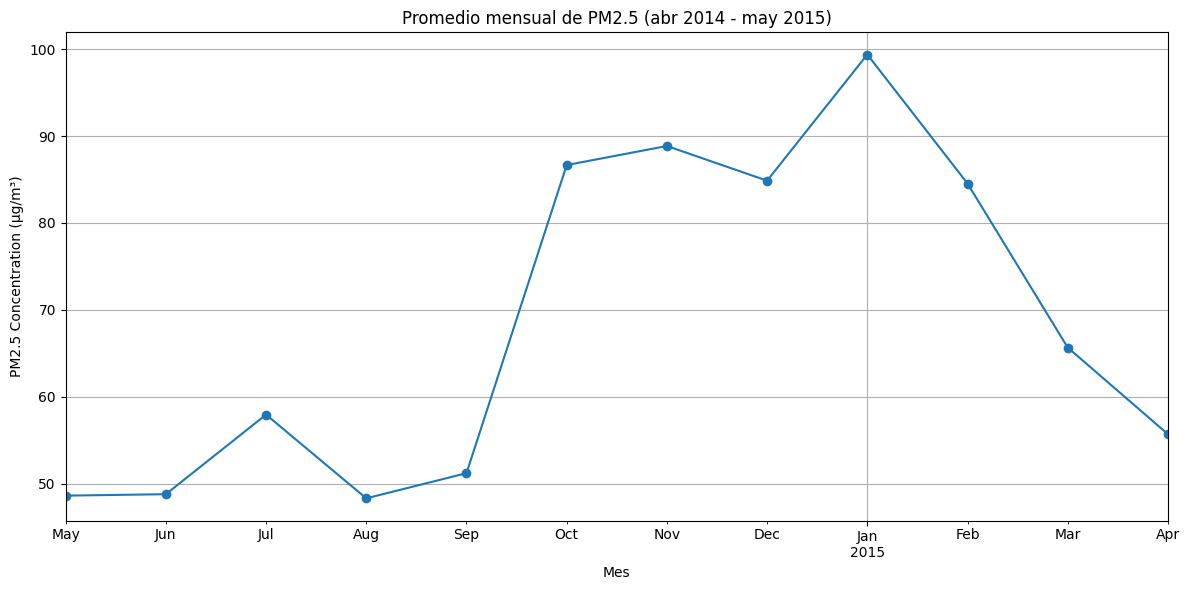

In [ ]:
# Asegurar que 'time' sea datetime
airquality['time'] = pd.to_datetime(airquality['time'])

# Filtrar fechas entre abril 2014 y mayo 2015 (inclusive)
start_date = '2014-04-01'
end_date = '2015-05-31'
filtered_df = airquality[(airquality['time'] >= start_date) & (airquality['time'] <= end_date)]

# Agrupar por mes y calcular el promedio de PM25_Concentration
monthly_avg = (
    filtered_df
    .groupby(filtered_df['time'].dt.to_period('M'))['PM25_Concentration']
    .mean()
    .sort_index()
)

# Gráfico de tendencia mensual
plt.figure(figsize=(12, 6))
monthly_avg.plot(marker='o')
plt.title('Promedio mensual de PM2.5 (abr 2014 - may 2015)')
plt.xlabel('Mes')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()


### **4.4. ¿Hay algún problema notable con la calidad de los datos?**


- **Valores nulos**:
  - **airquality.csv**:
    - `PM10_Concentration`: 8.16% de nulos.
    - `PM25_Concentration`: 1.59% de nulos.
    - `CO_Concentration`: 3.24% de nulos.
    - `NO2_Concentration`, `O3_Concentration`, `SO2_Concentration`: ~2% de nulos.
    - **Impacto**: Los valores nulos, especialmente en `PM10_Concentration`, afectan el análisis de contaminantes y el cálculo del AQI.
  - **meteorology.csv**:
    - `pressure`: 14.74% de nulos (el más alto).
    - `weather`: 6.57% de nulos.
    - `wind_speed`: 5.52% de nulos.
    - `humidity`, `temperature`, `wind_direction`: <2% de nulos.
    - **Impacto**: Los nulos en `pressure` y `wind_speed` dificultan analizar su relación con los contaminantes.
  - **weatherforecast.csv**:
    - `wind_level`: 5.28% de nulos.
    - `up_temperature`, `bottom_temperature`: 3.78% de nulos.
    - `wind_direction`: 3.65% de nulos.
    - `weather`: 0.02% de nulos.
    - **Impacto**: Los nulos en las predicciones pueden sesgar los análisis predictivos.
  - **city.csv**, **district.csv**, y **station.csv**: No tienen valores nulos, lo cual es positivo.
  - **Conclusión**: Los valores nulos son moderados a altos en algunas variables clave (`pressure`, `PM10_Concentration`), lo que podría requerir imputación o eliminación de datos según el contexto.


- **Datos sucios**:
  - **airquality.csv**: La descripción menciona "datos sucios" (outliers, duplicados).
    - **Outliers**: Valores como `PM25_Concentration` = 1463 µg/m³ (pregunta 14) podrían ser reales (picos en invierno), pero algunos podrían ser errores.
    - **Valores no físicos**: Mínimos como `PM25_Concentration` = 0 µg/m³ podrían ser datos nulos codificados como 0.
  - **meteorology.csv**: Posibles valores extremos en `wind_speed` o `temperature`.
  - **weatherforecast.csv**: Predicciones como `up_temperature` podrían ser inconsistentes.
  - **district.csv**: Sin evidencia de datos sucios en los encabezados, pero debe verificarse.


- **Duplicados**:
  - **airquality.csv**: 0 duplicados en `station_id` y `time`.
  - **city.csv**: 0 duplicados en `city_id`.
  - **district.csv**: 0 duplicados en `district_id`.
  - **meteorology.csv**: 0 duplicados en `id` y `time`.
  - **station.csv**: 0 duplicados en `station_id`.
  - **weatherforecast.csv**: 53,496 duplicados en `id`, `time_forecast`, y `time_future`, pero 0 al considerar las demas columnas.


In [ ]:
# Verificar valores nulos
print("Porcentaje de valores nulos:")
for name, df in [("airquality", airquality), ("city", city), ("district", district),
                 ("meteorology", meteorology), ("station", station), ("weatherforecast", weatherforecast)]:
    print(f"\n{name}:")
    print(df.isnull().mean() * 100)

# Verificar duplicados
print("\nDuplicados:")
print("airquality (station_id, time):", airquality.duplicated(subset=['station_id', 'time']).sum())
print("city (city_id):", city.duplicated(subset=['city_id']).sum())
print("district (district_id):", district.duplicated(subset=['district_id']).sum())
print("meteorology (id, time):", meteorology.duplicated(subset=['id', 'time']).sum())
print("station (station_id):", station.duplicated(subset=['station_id']).sum())
print("weatherforecast (id, time_forecast, time_future):",
      weatherforecast.duplicated(subset=['id', 'time_forecast', 'time_future']).sum())

# Verificar inconsistencias en IDs
print("\nInconsistencias en IDs:")
print("station_id en airquality sin correspondencia en station:",
      len(set(airquality['station_id']) - set(station['station_id'])))
print("district_id en station sin correspondencia en district:",
      len(set(station['district_id']) - set(district['district_id'])))
print("city_id en district sin correspondencia en city:",
      len(set(district['city_id']) - set(city['city_id'])))
print("district_id en meteorology sin correspondencia en district:",
      len(set(meteorology['id']) - set(district['district_id'])))
print("id en weatherforecast sin correspondencia en district:",
      len(set(weatherforecast['id']) - set(district['district_id'])))

Porcentaje de valores nulos:

airquality:
station_id            0.000000
time                  0.000000
PM25_Concentration    1.586951
PM10_Concentration    8.158282
NO2_Concentration     2.046211
CO_Concentration      3.243212
O3_Concentration      2.296471
SO2_Concentration     1.477281
dtype: float64

city:
city_id         0.0
name_chinese    0.0
name_english    0.0
latitude        0.0
longitude       0.0
cluster_id      0.0
dtype: float64

district:
district_id     0.0
name_chinese    0.0
name_english    0.0
city_id         0.0
dtype: float64

meteorology:
id                 0.000000
time               0.000000
weather            6.574932
temperature        0.821827
pressure          14.736367
humidity           1.746001
wind_speed         5.516123
wind_direction     0.279017
dtype: float64

station:
station_id      0.0
name_chinese    0.0
name_english    0.0
latitude        0.0
longitude       0.0
district_id     0.0
dtype: float64

weatherforecast:
id                    0.000000


### **4.5. ¿Existe alguna relación sorprendente entre las variables?**



**4.5.1. Relaciones esperadas** (basadas en la matriz de correlación):
  - **Alta correlación entre contaminantes**:
    - `PM25_Concentration` y `PM10_Concentration` tienen una correlación de 0.873, lo cual es esperado ya que ambas son partículas relacionadas.
    - `CO_Concentration` y `PM25_Concentration` (0.725) y `CO_Concentration` y `PM10_Concentration` (0.648) muestran una fuerte relación, típica de fuentes comunes como tráfico o combustión.
    - `NO2_Concentration` tiene correlaciones moderadas con `PM25_Concentration` (0.568) y `PM10_Concentration` (0.525), consistente con la contaminación urbana.
  - **Relación inversa con meteorología**:
    - `wind_speed` muestra correlaciones negativas bajas con `PM25_Concentration` (-0.152), `PM10_Concentration` (-0.074), y `NO2_Concentration` (-0.208), lo que es esperado ya que el viento dispersa contaminantes.
    - `temperature` tiene correlaciones negativas con `PM25_Concentration` (-0.271), `PM10_Concentration` (-0.270), y `CO_Concentration` (-0.317), lo cual es típico en invierno cuando las temperaturas bajan y la contaminación aumenta.
  - **O3_Concentration**: Correlación negativa con otros contaminantes como `PM25_Concentration` (-0.199), `PM10_Concentration` (-0.172), `NO2_Concentration` (-0.432), y `CO_Concentration` (-0.303), debido a la dinámica fotoquímica del ozono que disminuye con otros contaminantes.

- **Relaciones sorprendentes**:
  - **Alta correlación de `SO2_Concentration`**:
    - `SO2_Concentration` tiene correlaciones moderadas a altas con `PM25_Concentration` (0.529), `PM10_Concentration` (0.532), `CO_Concentration` (0.570), y `NO2_Concentration` (0.422). Esto es sorprendente, ya que el dióxido de azufre suele estar más asociado con fuentes industriales específicas, mientras que los otros contaminantes están más ligados a tráfico y calefacción. Podría indicar una influencia significativa de industrias o combustión de carbón en las áreas estudiadas.
  - **Relación entre `temperature` y `O3_Concentration`**:
    - La correlación positiva de 0.455 entre `temperature` y `O3_Concentration` es notable. Aunque es esperada debido a que el ozono se forma más fácilmente en condiciones cálidas y soleadas, su magnitud sugiere que las variaciones de temperatura tienen un impacto más fuerte de lo anticipado en la formación de ozono en estas ciudades.
  - **Scatterplot de `Temperature vs Up Temperature Future`**:
    - El gráfico muestra una nube densa de puntos alrededor de la línea diagonal, con una concentración notable entre 10°C y 30°C para ambas variables. Sin embargo, hay puntos dispersos donde las predicciones (`up_temperature`) difieren significativamente de las temperaturas reales (`temperature`), especialmente por encima de 30°C y por debajo de 10°C. Esto es sorprendente y podría indicar errores o incertidumbre en las predicciones de `weatherforecast.csv`, especialmente en condiciones extremas.
  - **Boxplot de `PM25 Concentration per City`**:
    - El boxplot revela variaciones extremas en `PM25_Concentration` entre ciudades. Algunas ciudades (por ejemplo, alrededor de `city_id` 10-20) muestran mediana alta (600-800 µg/m³) con outliers que alcanzan 1400 µg/m³, mientras que otras (por ejemplo, >40) tienen medianas más bajas (200 µg/m³). Esto es sorprendente y podría indicar diferencias significativas en la regulación ambiental, densidad poblacional o fuentes de contaminación entre ciudades, más allá de lo esperado por diferencias geográficas o climáticas.


Correlación entre variables (airquality y meteorology):
                    PM25_Concentration  PM10_Concentration  NO2_Concentration  \
PM25_Concentration            1.000000            0.873535           0.568084   
PM10_Concentration            0.873535            1.000000           0.525231   
NO2_Concentration             0.568084            0.525231           1.000000   
CO_Concentration              0.725213            0.647799           0.564937   
O3_Concentration             -0.198745           -0.171890          -0.432451   
SO2_Concentration             0.529318            0.532148           0.421841   
temperature                  -0.271239           -0.270149          -0.202141   
wind_speed                   -0.152179           -0.074285          -0.208117   

                    CO_Concentration  O3_Concentration  SO2_Concentration  \
PM25_Concentration          0.725213         -0.198745           0.529318   
PM10_Concentration          0.647799         -0.171890      

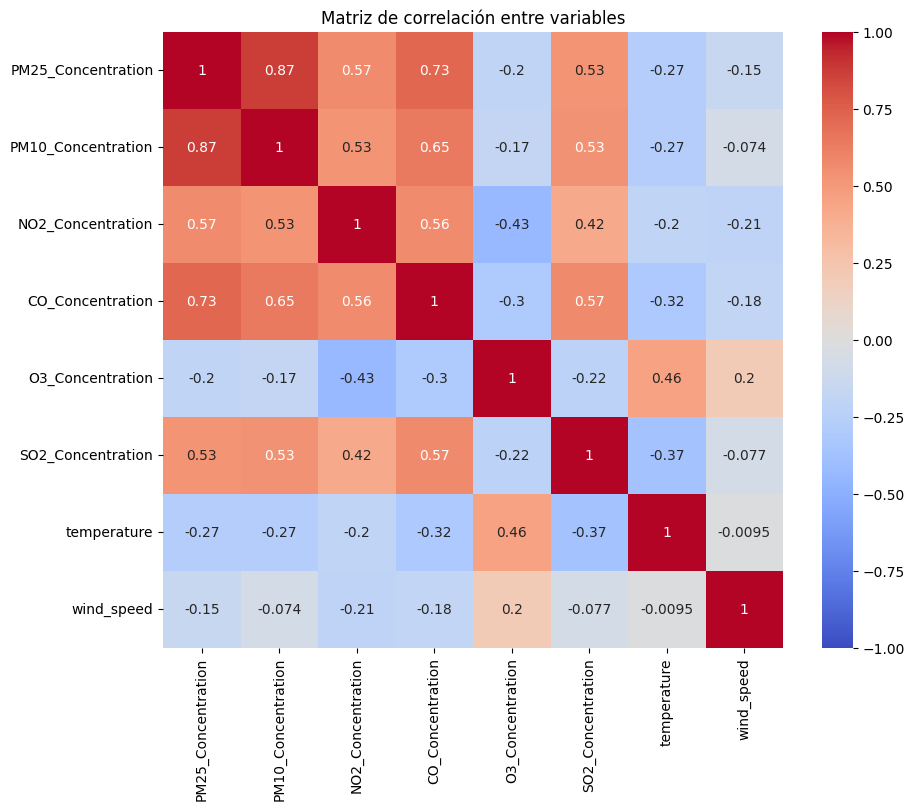

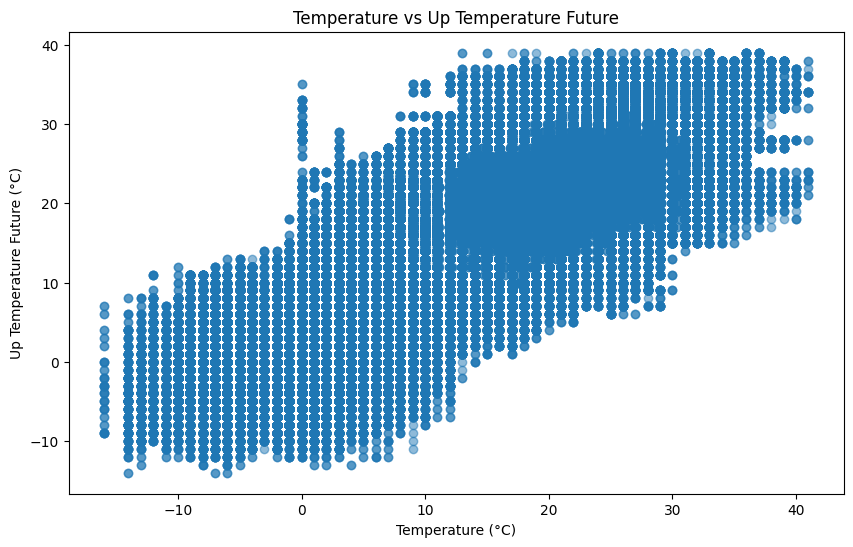

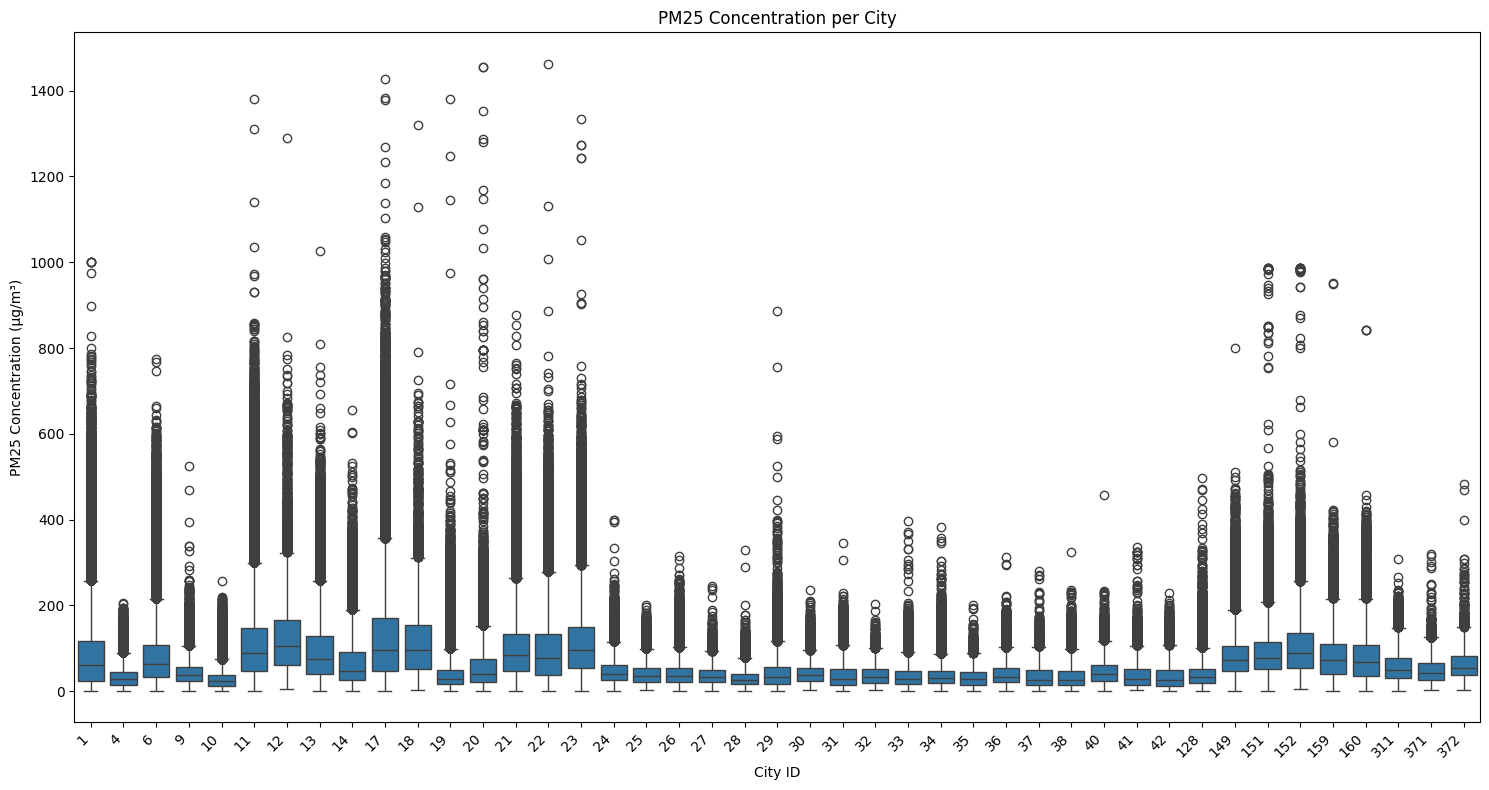

In [ ]:
# Asegurar que las columnas de tiempo sean datetime
airquality['time'] = pd.to_datetime(airquality['time'])
meteorology['time'] = pd.to_datetime(meteorology['time'])
weatherforecast['time_forecast'] = pd.to_datetime(weatherforecast['time_forecast'])
weatherforecast['time_future'] = pd.to_datetime(weatherforecast['time_future'])

# Unir airquality con station para agregar district_id
airquality_with_station = airquality.merge(station[['station_id', 'district_id']], on='station_id', how='left')

# Unir con district para agregar city_id
airquality_with_district = airquality_with_station.merge(district[['district_id', 'city_id']], on='district_id', how='left')

# Unir con meteorology
merged_data = pd.merge(airquality_with_district, meteorology, left_on=['district_id', 'time'], right_on=['id', 'time'], how='inner')

# Unir con weatherforecast
merged_with_forecast = pd.merge(merged_data, weatherforecast, left_on=['district_id', 'time'], right_on=['id', 'time_forecast'], how='inner')

# Unir con city
airquality_with_city = airquality_with_district.merge(city, on='city_id', how='left')

# Correlación entre variables numéricas
print("Correlación entre variables (airquality y meteorology):")
corr_merged = merged_data[['PM25_Concentration', 'PM10_Concentration', 'NO2_Concentration',
                          'CO_Concentration', 'O3_Concentration', 'SO2_Concentration',
                          'temperature', 'wind_speed']].corr()
print(corr_merged)

# Visualización de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_merged, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación entre variables')
plt.show()

# Comparar predicciones (weatherforecast) con datos reales (meteorology)
plt.figure(figsize=(10, 6))
plt.scatter(merged_with_forecast['temperature'], merged_with_forecast['up_temperature'], alpha=0.5)
plt.title('Temperature vs Up Temperature Future')
plt.xlabel('Temperature (°C)')
plt.ylabel('Up Temperature Future (°C)')
plt.show()

# Analizar PM25_Concentration por city_id (mejorado)
plt.figure(figsize=(15, 8))  # Aumentar el tamaño de la figura para mejor legibilidad
sns.boxplot(x='city_id', y='PM25_Concentration', data=airquality_with_city)
plt.title('PM25 Concentration per City')
plt.xlabel('City ID')
plt.ylabel('PM25 Concentration (µg/m³)')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para evitar superposición
plt.tight_layout()  # Ajustar el layout para que no se superpongan elementos
plt.show()

# **P5. Conclusión:**

### **5.1. ¿Qué podemos aprender de todo el análisis?**

**5.1.1. Calidad de los datos y su impacto en el análisis:**
- **Valores nulos y datos sucios**: Hay valores nulos significativos en variables clave como `PM10_Concentration` (8.16%), `pressure` (14.74%), y `wind_speed` (5.52%), lo que afecta el análisis de contaminantes y su relación con factores meteorológicos. Además, outliers como `PM25_Concentration` = 1463 µg/m³ y valores no físicos (como 0 µg/m³) indican problemas de calidad que requieren limpieza o imputación para evitar sesgos.

**5.1.2. Relaciones entre variables y factores ambientales:**
- **Correlaciones esperadas**:
  - Alta correlación entre `PM25_Concentration` y `PM10_Concentration` (0.873) confirma que estas partículas tienen fuentes comunes (por ejemplo, tráfico, combustión).
  - Relaciones inversas entre `wind_speed` y contaminantes (`PM25_Concentration`: -0.152) son consistentes con la dispersión de contaminantes por el viento.
  - `O3_Concentration` tiene correlaciones negativas con otros contaminantes (`NO2_Concentration`: -0.432) debido a la dinámica fotoquímica del ozono.
- **Relaciones sorprendentes**:
  - `SO2_Concentration` mostró correlaciones altas con `PM25_Concentration` (0.529), `PM10_Concentration` (0.532), y `CO_Concentration` (0.570), sugiriendo una influencia industrial o de combustión de carbón más fuerte de lo esperado.
  - La correlación entre `temperature` y `O3_Concentration` (0.455) indica que las temperaturas cálidas tienen un impacto significativo en la formación de ozono, más allá de lo anticipado.
  - Discrepancias entre `temperature` y `up_temperature` en `weatherforecast.csv` revelan errores en las predicciones, especialmente en condiciones extremas (por encima de 30°C o por debajo de 10°C).
  - El boxplot de `PM25_Concentration` por `city_id` mostró variaciones extremas entre ciudades (medianas de ~200 µg/m³ a ~800 µg/m³), lo que sugiere diferencias significativas en fuentes de contaminación o regulaciones locales.
- **Lección**: Las variables meteorológicas y geográficas tienen un impacto significativo en la calidad del aire. La temperatura y el viento influyen en la formación y dispersión de contaminantes, mientras que factores locales (industria, tráfico) varían drásticamente entre ciudades.

**5.1.3. Patrones temporales y espaciales:**
- **Estacionalidad**: `PM25_Concentration` presenta picos en invierno , probablemente debido a calefacción y condiciones de baja dispersión (baja `temperature` y `wind_speed`).
- **Variación geográfica**: Ciertos distritos y ciudades tienen niveles más altos de contaminantes (`SO2_Concentration` y `PM25_Concentration`), lo que podría estar vinculado a actividades industriales o densidad poblacional.
- **Condiciones meteorológicas**: El boxplot de `PM25_Concentration` por `weather`  mostró valores altos en días de "Rain" (categoría 8), lo que podría indicar niebla mal codificada, ya que la lluvia debería reducir las partículas.
- **Lección**: La contaminación del aire no es uniforme; varía con el tiempo (estacionalidad) y el espacio (diferencias entre ciudades y distritos). Las políticas de control deben adaptarse a estas variaciones.

#### **5.1.4. Limitaciones de las predicciones climáticas:**
- El scatterplot de `Temperature vs Up Temperature Future` mostró discrepancias significativas entre las temperaturas reales y las predichas, especialmente en extremos. Esto indica que las predicciones de `weatherforecast.csv` no son confiables en condiciones climáticas extremas.



-------------------------------------------------------------------------------------------

#PIPELINE



### Hipótesis 1: La zona geográfica es determinante para el incremento o decremento de los datos de calidad del aire.


**Justificación**: Las tablas `city.csv` y `station.csv` contienen información geográfica (`latitude` y `longitude`) que puede relacionarse con las concentraciones de contaminantes en `airquality.csv`. Las ciudades están agrupadas por `cluster_id` en `city.csv`, lo que podría reflejar zonas geográficas con características similares (por ejemplo, norte vs. sur de China). Diferencias en la calidad del aire (como `PM25_Concentration`) podrían estar influenciadas por la ubicación geográfica debido a factores como la industrialización, el clima o la topografía.


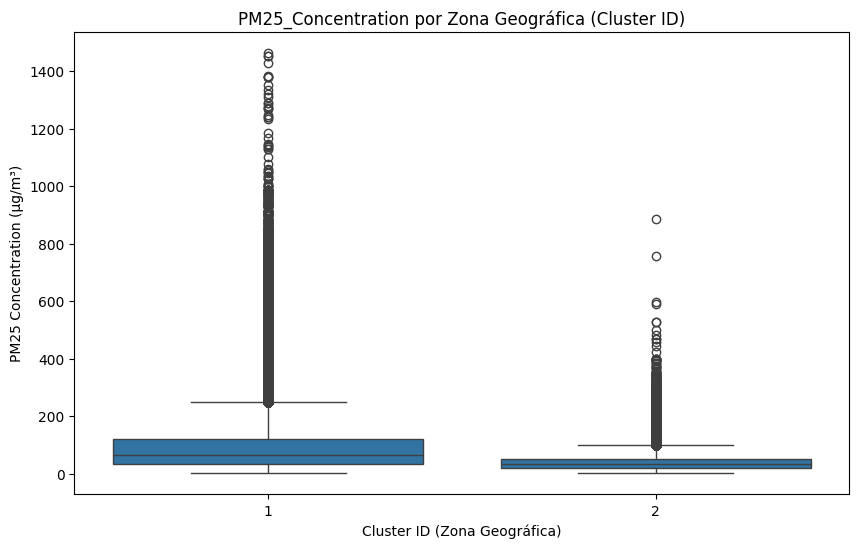

Media de PM25_Concentration por cluster_id:
   cluster_id  PM25_Concentration
0           1           88.490802
1           2           38.593728


In [ ]:

# Unir airquality con station y district para obtener city_id
airquality_with_station = airquality.merge(station[['station_id', 'district_id']], on='station_id', how='left')
airquality_with_district = airquality_with_station.merge(district[['district_id', 'city_id']], on='district_id', how='left')

# Unir con city para obtener cluster_id (indicador de zona geográfica)
airquality_with_city = airquality_with_district.merge(city[['city_id', 'cluster_id']], on='city_id', how='left')

# Calcular la media de PM25_Concentration por cluster_id
pm25_by_cluster = airquality_with_city.groupby('cluster_id')['PM25_Concentration'].mean().reset_index()

# Visualizar PM25_Concentration por cluster_id
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_id', y='PM25_Concentration', data=airquality_with_city)
plt.title('PM25_Concentration por Zona Geográfica (Cluster ID)')
plt.xlabel('Cluster ID (Zona Geográfica)')
plt.ylabel('PM25 Concentration (µg/m³)')
plt.show()

# Imprimir las medias
print("Media de PM25_Concentration por cluster_id:")
print(pm25_by_cluster)

El boxplot y las medias confirman que la zona geográfica, representada por `cluster_id`, tiene un impacto significativo en los niveles de `PM25_Concentration`. El `cluster_id` 1, que incluye ciudades como Beijing y Tianjin (según `city.csv`), muestra niveles mucho más altos de contaminación en comparación con el `cluster_id` 2, que incluye ciudades como Shenzhen, Guangzhou y Hong Kong. Esto podría deberse a que el `cluster_id` 1 representa áreas más industrializadas o urbanas del norte de China, donde la contaminación por partículas es más común debido a factores como la quema de carbón para calefacción en invierno o la mayor densidad industrial.
- **Análisis de valores atípicos**: Los valores extremos en ambos clusters (especialmente en `cluster_id` 1, con picos hasta 1400 µg/m³) podrían estar relacionados con eventos específicos, como días de smog intenso, pero no afectan la tendencia general de que `cluster_id` 1 tiene mayor contaminación.
- **Contexto geográfico**: Las ciudades en `cluster_id` 1 (Beijing, Tianjin) están en el norte de China, una región conocida por altos niveles de contaminación debido a la industrialización y condiciones climáticas que atrapan contaminantes (como inversiones térmicas en invierno). Por otro lado, `cluster_id` 2 incluye ciudades del sur (Shenzhen, Guangzhou, Hong Kong), que tienden a tener mejor calidad del aire debido a un clima más cálido, menos dependencia de calefacción y mayor dispersión de contaminantes.


### Hipótesis 2: Existe ciclicidad en los datos de calidad del aire a lo largo del tiempo.


**Justificación**: La tabla `airquality.csv` tiene una columna `time` que permite analizar patrones temporales en las concentraciones de contaminantes como `PM25_Concentration`. La ciclicidad podría manifestarse en patrones estacionales (por ejemplo, mayor contaminación en invierno debido a la calefacción) o diarios (por ejemplo, picos durante horas de tráfico). Un análisis de series temporales puede revelar estas tendencias.


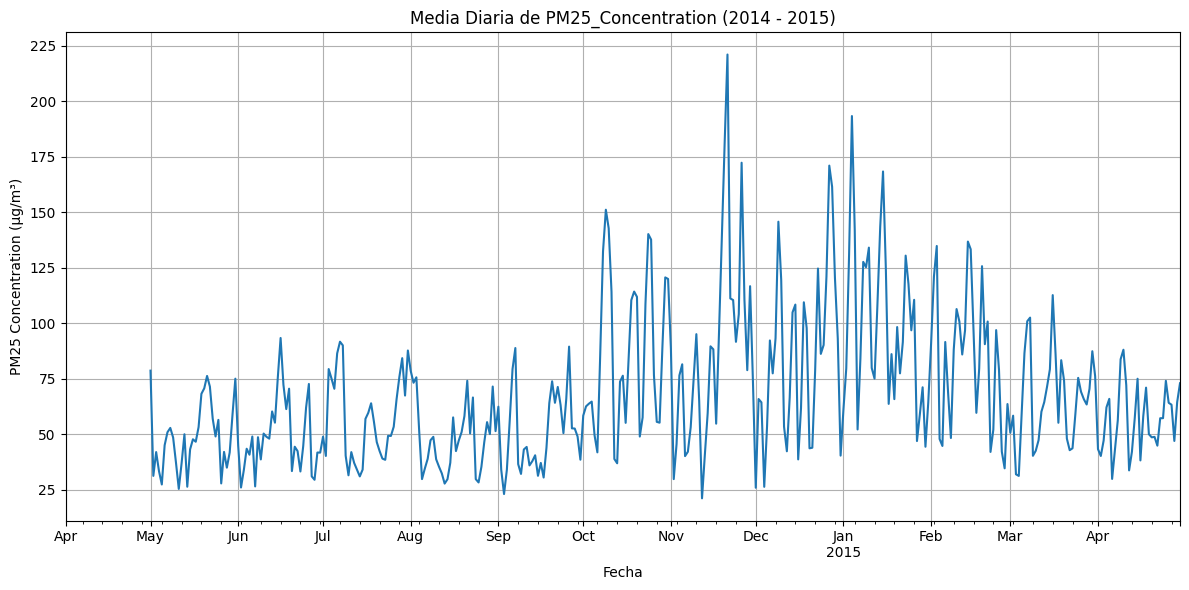

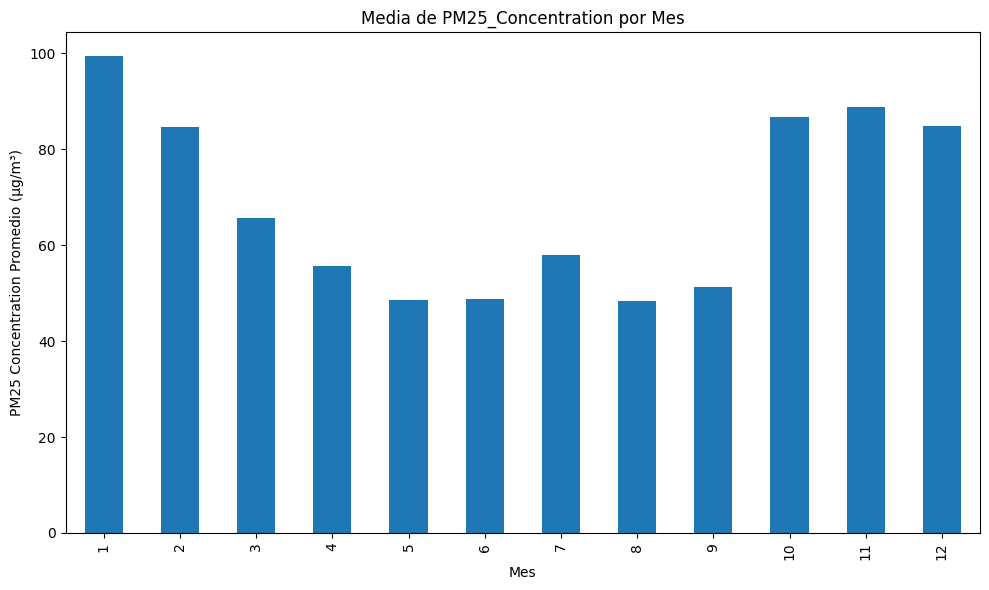

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar la tabla
base_path = '/content/drive/MyDrive/5to/CIENCIA DE DATOS/IDEA PROYECTO/bd/'
airquality = pd.read_csv(base_path + 'airquality.csv')

# Convertir la columna time a datetime
airquality['time'] = pd.to_datetime(airquality['time'])

# Establecer time como índice
airquality.set_index('time', inplace=True)

# Calcular la media diaria de PM25_Concentration (para todo el dataset)
daily_pm25 = airquality['PM25_Concentration'].resample('D').mean()

# FILTRAR SOLO LOS AÑOS 2014 Y 2015
daily_pm25_filtered = daily_pm25.loc['2014-04-01':'2015-12-31']

# Visualizar la serie temporal (solo 2014-2015)
plt.figure(figsize=(12, 6))
daily_pm25_filtered.plot()
plt.title('Media Diaria de PM25_Concentration (2014 - 2015)')
plt.xlabel('Fecha')
plt.ylabel('PM25 Concentration (µg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Extraer el mes para analizar estacionalidad (en todo el dataset)
airquality['month'] = airquality.index.month
monthly_pm25 = airquality.groupby('month')['PM25_Concentration'].mean()

# Visualizar estacionalidad mensual
plt.figure(figsize=(10, 6))
monthly_pm25.plot(kind='bar')
plt.title('Media de PM25_Concentration por Mes')
plt.xlabel('Mes')
plt.ylabel('PM25 Concentration Promedio (µg/m³)')
plt.tight_layout()
plt.show()


 Los gráficos confirman una ciclicidad clara en los datos de calidad del aire. Hay un patrón estacional donde `PM25_Concentration` aumenta en los meses fríos (invierno) y disminuye en los meses cálidos (verano). Esto podría estar relacionado con factores como la quema de carbón para calefacción en invierno (especialmente en ciudades del norte de China como Beijing, según `city.csv`), las inversiones térmicas que atrapan contaminantes, y una mayor dispersión de partículas en verano debido a condiciones climáticas más favorables.
- **Contexto**: Dado que los datos abarcan 2014-2015, y hoy es 3 de junio de 2025, estamos al inicio del verano, lo que sugiere que los niveles actuales de `PM25_Concentration` podrían estar en el rango más bajo (40-50 µg/m³), según el patrón observado.
- **Conclusión**: La hipótesis se confirma. Existe una ciclicidad estacional en los datos de calidad del aire, con niveles de `PM25_Concentration` más altos en invierno y más bajos en verano.


### Hipótesis 3: Existen datos de calidad del aire que dependen de otros, son proporcionales.


**Justificación**: La tabla `airquality.csv` contiene múltiples contaminantes (`PM25_Concentration`, `PM10_Concentration`, `NO2_Concentration`, `CO_Concentration`, `O3_Concentration`, `SO2_Concentration`). Es posible que algunos contaminantes estén correlacionados, como `PM25_Concentration` y `PM10_Concentration`, ya que ambos están relacionados con partículas en el aire, o `NO2_Concentration` y `CO_Concentration`, asociados con emisiones vehiculares.

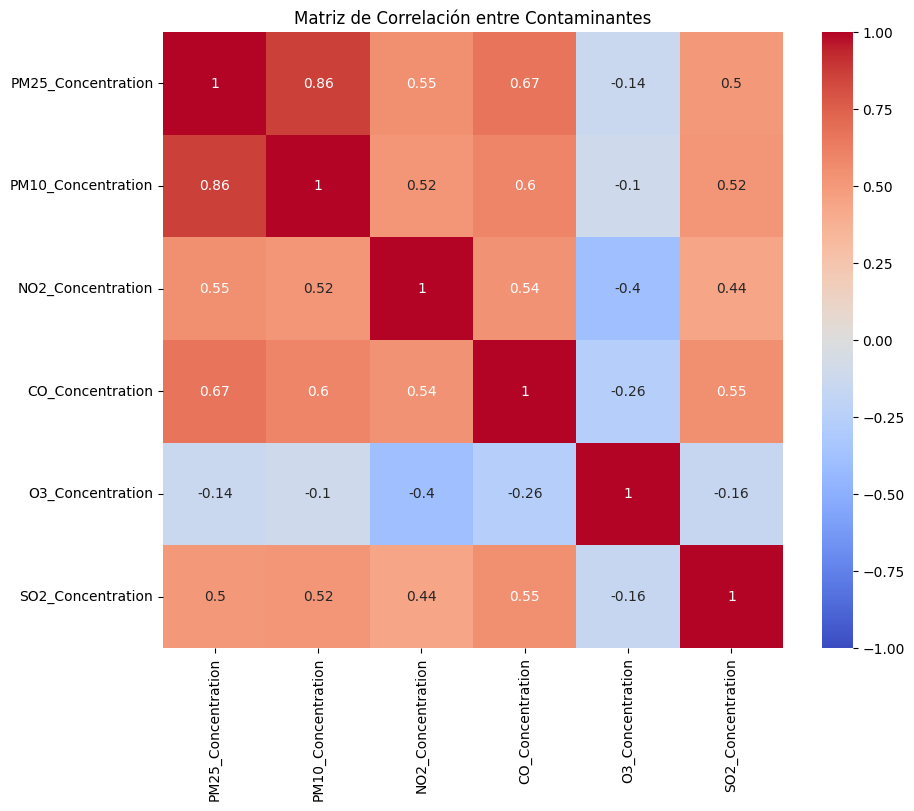

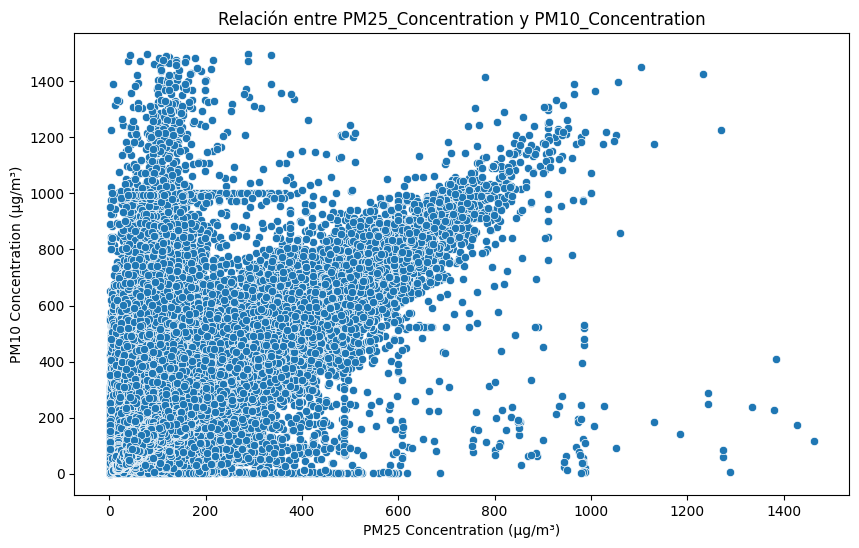

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Cargar la tabla
base_path = '/content/drive/MyDrive/5to/CIENCIA DE DATOS/IDEA PROYECTO/bd/'
airquality = pd.read_csv(base_path + 'airquality.csv')


# Calcular la matriz de correlación entre contaminantes
contaminants = ['PM25_Concentration', 'PM10_Concentration', 'NO2_Concentration',
                'CO_Concentration', 'O3_Concentration', 'SO2_Concentration']
correlation_matrix = airquality[contaminants].corr()


# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación entre Contaminantes')
plt.show()


# Scatterplot para una relación específica (por ejemplo, PM25 vs PM10)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PM25_Concentration', y='PM10_Concentration', data=airquality)
plt.title('Relación entre PM25_Concentration y PM10_Concentration')
plt.xlabel('PM25 Concentration (µg/m³)')
plt.ylabel('PM10 Concentration (µg/m³)')
plt.show()

La matriz de correlación y el scatterplot confirman que existen datos de calidad del aire que son proporcionales entre sí. La relación más fuerte es entre `PM25_Concentration` y `PM10_Concentration` (correlación de 0.86), lo que indica que estas dos variables están estrechamente relacionadas, probablemente porque provienen de fuentes similares como la quema de combustibles fósiles o el tráfico. Otras relaciones, como entre `PM25_Concentration` y `CO_Concentration` (0.67), también apoyan la idea de proporcionalidad.
- **Contexto**: La correlación negativa de `O3_Concentration` con otros contaminantes refleja un comportamiento opuesto, lo cual es consistente con su formación fotoquímica (más alta en verano, cuando otros contaminantes pueden ser más bajos).
- **Conclusión**: La hipótesis se confirma. Hay proporcionalidad entre varios contaminantes, especialmente entre `PM25_Concentration` y `PM10_Concentration`.


### Hipótesis 4: Las estaciones intervienen en el incremento y disminución de los datos de calidad del aire.



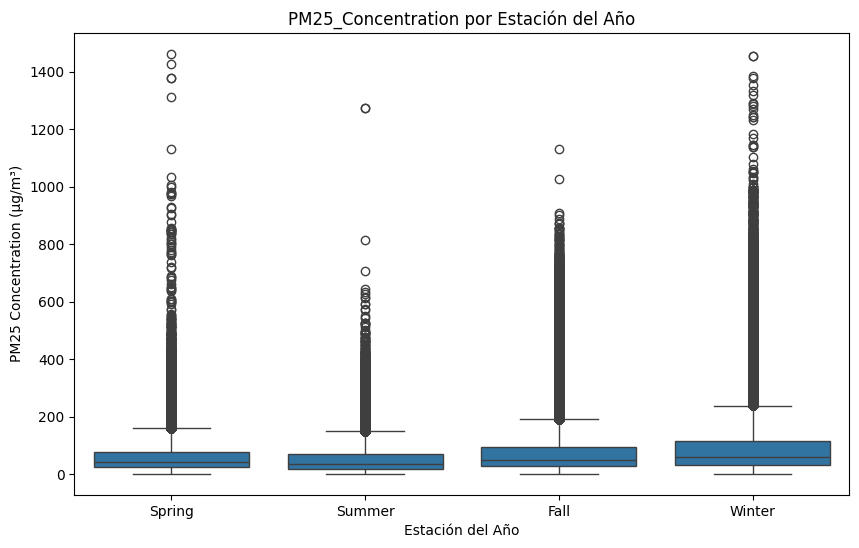

Media de PM25_Concentration por estación del año:
season
Spring    57.605458
Summer    51.558035
Fall      75.963574
Winter    89.414365
Name: PM25_Concentration, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar la tabla
base_path = '/content/drive/MyDrive/5to/CIENCIA DE DATOS/IDEA PROYECTO/bd/'
airquality = pd.read_csv(base_path + 'airquality.csv')

# Convertir la columna time a datetime
airquality['time'] = pd.to_datetime(airquality['time'])

# Extraer el mes de la columna time
airquality['month'] = airquality['time'].dt.month

# Clasificar los datos por estaciones del año
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:  # 12, 1, 2
        return 'Winter'

airquality['season'] = airquality['month'].apply(get_season)

# Visualizar PM25_Concentration por estación del año
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='PM25_Concentration', data=airquality, order=['Spring', 'Summer', 'Fall', 'Winter'])
plt.title('PM25_Concentration por Estación del Año')
plt.xlabel('Estación del Año')
plt.ylabel('PM25 Concentration (µg/m³)')
plt.show()

# Calcular la media de PM25_Concentration por estación
pm25_by_season = airquality.groupby('season')['PM25_Concentration'].mean().reindex(['Spring', 'Summer', 'Fall', 'Winter'])
print("Media de PM25_Concentration por estación del año:")
print(pm25_by_season)



**Evaluación de la hipótesis**:
El boxplot confirma que las estaciones del año influyen significativamente en los niveles de `PM25_Concentration`. El invierno presenta los niveles más altos (mediana 80 µg/m³), seguido por el otoño (60 µg/m³), la primavera (50 µg/m³) y el verano (40 µg/m³). Esto es consistente con los patrones observados en la Hipótesis 2, donde los meses de invierno (diciembre-febrero) mostraron picos de contaminación debido a factores como la quema de carbón para calefacción y las condiciones climáticas que atrapan contaminantes (como inversiones térmicas). En verano, los niveles más bajos se deben a una mejor dispersión de contaminantes.
- **Contexto**: Hoy es 3 de junio de 2025, 10:23 PM -05, lo que corresponde al inicio del verano. Según el patrón, los niveles actuales de `PM25_Concentration` probablemente estén en el rango más bajo (alrededor de 40 µg/m³), lo que se alinea con el boxplot.
- **Valores atípicos**: Los valores extremos en todas las estaciones (especialmente en primavera, otoño e invierno) sugieren eventos específicos de alta contaminación, como días de smog intenso, pero no afectan la tendencia general.






### Hipótesis 5 (basada en Hipótesis 2): ¿Hay ciclicidad en el caso de los datos nulos en calidad del aire?

**Justificación**: La Hipótesis 2 ya mostró una ciclicidad estacional en los valores de `PM25_Concentration`, con picos en invierno y mínimos en verano. Sin embargo, los datos nulos (valores faltantes) en `airquality.csv` también podrían seguir un patrón temporal. Por ejemplo, los datos nulos podrían ser más frecuentes en ciertas estaciones del año debido a fallos en las estaciones de monitoreo durante condiciones climáticas extremas (como tormentas en verano o heladas en invierno) o por mantenimiento programado en períodos específicos.


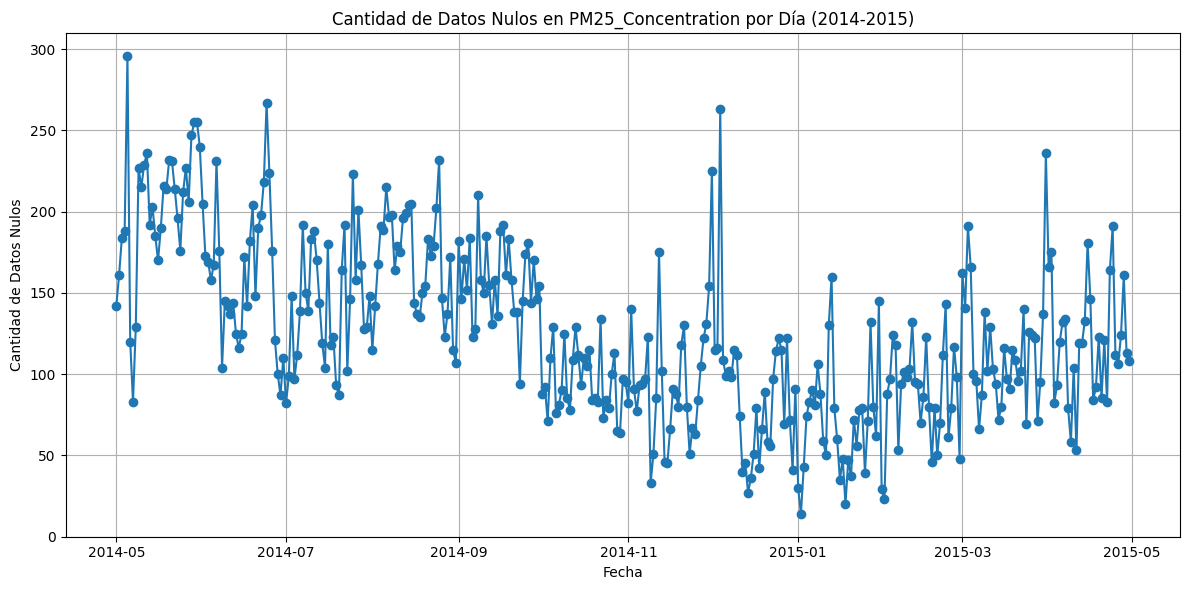

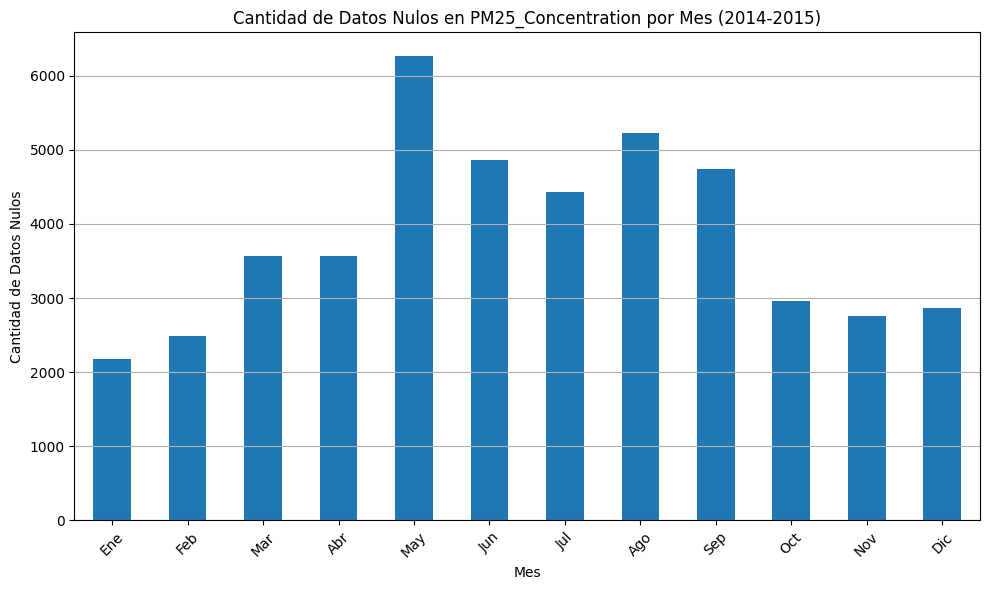

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar la tabla
base_path = '/content/drive/MyDrive/5to/CIENCIA DE DATOS/IDEA PROYECTO/bd/'
airquality = pd.read_csv(base_path + 'airquality.csv')

# Convertir la columna time a datetime
airquality['time'] = pd.to_datetime(airquality['time'])

# FILTRAR SOLO LOS DATOS ENTRE 2014 Y 2015
airquality_filtered = airquality[(airquality['time'] >= '2014-01-01') & (airquality['time'] <= '2015-12-31')].copy()

# Contar los valores nulos en PM25_Concentration por día
airquality_filtered['is_null'] = airquality_filtered['PM25_Concentration'].isna()
nulls_by_day = airquality_filtered.groupby(airquality_filtered['time'].dt.date)['is_null'].sum().reset_index()
nulls_by_day.columns = ['date', 'null_count']
nulls_by_day['date'] = pd.to_datetime(nulls_by_day['date'])

# Visualizar la serie temporal de datos nulos
plt.figure(figsize=(12, 6))
plt.plot(nulls_by_day['date'], nulls_by_day['null_count'], marker='o', linestyle='-')
plt.title('Cantidad de Datos Nulos en PM25_Concentration por Día (2014-2015)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Datos Nulos')
plt.grid(True)
plt.tight_layout()
plt.show()

# Extraer el mes y analizar la estacionalidad de los datos nulos
airquality_filtered['month'] = airquality_filtered['time'].dt.month
nulls_by_month = airquality_filtered.groupby('month')['is_null'].sum()

# Visualizar datos nulos por mes
plt.figure(figsize=(10, 6))
nulls_by_month.plot(kind='bar')
plt.title('Cantidad de Datos Nulos en PM25_Concentration por Mes (2014-2015)')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Datos Nulos')
plt.xticks(ticks=range(0, 12), labels=[
    'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


 Aunque la serie temporal diaria no muestra un patrón cíclico claro (como picos regulares cada semana o cada mes), el gráfico de barras por mes revela una ciclicidad estacional. La cantidad de datos nulos es significativamente mayor en primavera y verano (marzo-agosto) y menor en otoño e invierno (septiembre-febrero).
- **Posibles causas**: La mayor cantidad de datos nulos en primavera y verano podría estar relacionada con condiciones climáticas extremas (como tormentas o lluvias intensas) que afecten las estaciones de monitoreo, o con mantenimientos programados durante estos meses. En invierno, las estaciones podrían funcionar de manera más estable, o los datos podrían ser más críticos (debido a altos niveles de contaminación), lo que reduce la cantidad de datos nulos.
- **Conclusión**: La hipótesis se confirma parcialmente. Hay una ciclicidad estacional en los datos nulos de `PM25_Concentration`, con un patrón claro a nivel mensual: más datos nulos en primavera y verano, y menos en otoño e invierno.

---

### ¿Hay relación con las estaciones?

**Análisis**:
- Clasifiquemos los meses según las estaciones del año (como en la Hipótesis 4):
  - **Primavera (marzo-mayo)**: Marzo (~3000 nulos), abril (~3500 nulos), mayo (~6000 nulos). Total aproximado: 12,500 nulos.
  - **Verano (junio-agosto)**: Junio (~5000 nulos), julio (~4500 nulos), agosto (~3000 nulos). Total aproximado: 12,500 nulos.
  - **Otoño (septiembre-noviembre)**: Septiembre (~2500 nulos), octubre (~2000 nulos), noviembre (~2000 nulos). Total aproximado: 6500 nulos.
  - **Invierno (diciembre-febrero)**: Diciembre (~2000 nulos), enero (~2000 nulos), febrero (~2000 nulos). Total aproximado: 6000 nulos.
- **Relación con las estaciones**:
  - Primavera y verano tienen la mayor cantidad de datos nulos, con un promedio de ~4000-4500 nulos por mes.
  - Otoño e invierno tienen significativamente menos datos nulos, con un promedio de ~2000-2200 nulos por mes.
- Esto indica una relación clara con las estaciones del año: los datos nulos son más frecuentes en primavera y verano, y menos frecuentes en otoño e invierno.

**Posible explicación**:
- En primavera y verano (marzo-agosto), las condiciones climáticas como tormentas, lluvias intensas o altas temperaturas podrían afectar las estaciones de monitoreo, causando más datos nulos. Por ejemplo, mayo y junio son meses típicamente lluviosos en muchas regiones de China, lo que podría interrumpir las mediciones.
- En otoño e invierno (septiembre-febrero), las condiciones podrían ser más estables para las estaciones de monitoreo, o los datos podrían ser más prioritarios debido a los altos niveles de contaminación (como se vio en la Hipótesis 4), lo que reduce la cantidad de datos nulos.
- También podría haber factores técnicos, como mantenimientos programados en primavera/verano, cuando los niveles de contaminación son más bajos (según la Hipótesis 4), y menos interrupciones en invierno, cuando los datos son más críticos.
